# Проект: Обучение с учителем: качество модели

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. Нам поручено разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.   

Заказчиком задачи сформированы в следующем виде:   
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».      
2. Нужно собрать данные по клиентам по следующим группам:
   - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
   - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
   - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
   - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.   
   
   
   Решение этих задач предполагается следующим способом:   
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.   
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.   
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения, которые могли бы увеличить покупательскую активность.


## План проекта

- Загрузим данные из файлов и изучим их;   
- Проведем предобработку данных (проверка типов данных, поиск пропусков, дубликатов); 
- Если будет необходимо, произведем корректировку данных.
- Проведем исследовательский анализ данных. Изучим все признаки, указанные в файлах. Изучим распределение этих признаков, наличие или отсутствие выбросов в данных;
- объединим данные из файлов `market_file.csv`, `market_money.csv` и `market_time.csv`. Разделим данные о прибыли от клиентов по периодам;
- проведем корреляционный анализ и изучим взаимосвязь признаков;
- подготовим данные для моделирования с помощью пайплайна. Создадим и обучим четыре вида модели машинного обучения;
- сравним их эффективность и выберем лучшую;
- Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP;
- Выполним сегментацию покупателей. Для этого используем результаты моделирования и данные о прибыльности покупателей из четвертого файла;
- Выберем группу покупателей и сформируем предложения, как увеличить её покупательскую активность;
- Составим общий вывод о проекте.

In [1]:
# библиотеку, возможно, нужно установить

!pip install phik -q

In [2]:
# библиотеку, возможно, нужно установить

!pip install shap -q

In [3]:
# загружаем библиотеки

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import phik
import shap

In [4]:
# загружаем модели машинного обучения

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [5]:
# загружаем метрики

from sklearn.metrics import roc_auc_score


# загружаем классы для работы с данными

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV)
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   LabelEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler)


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Загрузка данных

Для исследования нам передают четыре файла: `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`.   

В первом файле находятся следующие данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [7]:
# посмотрим первый файл

try:
    data_market_file = pd.read_csv('C:\\Users\\ElenaB\\Projects\\pj_07\\pj_Learning_with_teacher\\market_file.csv')
except:
    data_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')

data_market_file.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [8]:
# посмотрим информацию о файле

data_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

На первых десяти строках из файла мы видим, что данные прочитались корректно. Пропущенные значения отсутствуют. Типы данных соответствуют ожиданиям.   
Несколько разочаровывающе выглядит колонка "Ошибки_сервиса" - десятый пользователь всего 154 дня зарегистрирован на сайте, но уже столкнулся с 9 ошибками сервиса. А пятый пользователь зарегистрирован на сайте более 1000 дней и сталкивался с ошибками сервиса всего 3 раза. Возможно, мы не до конца понимаем, о каких ошибках сервиса может идти речь.   
Также не слишком понятна колонка "Неоплаченные_продукты_штук_квартал" - пользователь выбрал, но не купил товар? Или купил, но вернул? 

In [9]:
# приведем название колонок к общему виду

data_market_file = data_market_file.rename(columns={'Покупательская активность':'покупательская_активность',
                                        'Тип сервиса':'тип_сервиса',
                                        'Разрешить сообщать':'разрешить_сообщать'})
data_market_file.columns = data_market_file.columns.str.lower()

In [10]:
# проверим названия

data_market_file.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


Во втором файле `market_money.csv` находится таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

In [11]:
# посмотрим второй файл

try:
    data_market_money = pd.read_csv('C:\\Users\\ElenaB\\Projects\\pj_07\\pj_Learning_with_teacher\\market_money.csv')
except:
    data_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')

data_market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [12]:
# Посмотрим информацию о файле

data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Пропусков в данных пока нет. Записей ровно в три раза больше, чем в первом файле. Т.е. можно предположить, что на каждого клиента зафиксированы его траты за три последних месяца.   
Тип данных соответствуют ожидаемым. Размер выручки представлен, предположительно, в рублях.

In [13]:
# приведем название колонок к общему виду

data_market_money.columns = data_market_money.columns.str.lower()
data_market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


В третьем файле `market_time.csv` находится таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

In [14]:
# посмотрим третий файл

try:
    data_market_time = pd.read_csv('C:\\Users\\ElenaB\\Projects\\pj_07\\pj_Learning_with_teacher\\market_time.csv')
except:
    data_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')

data_market_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [15]:
# посмотрим информацию о файле

data_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


В этом файле записаны данные о проведенном на сайте времени только за два периода: текущий и прошлый месяц, в отличие от второго файла, где учитывались три периода. Да еще и название параметра указано с опечаткой "предыдцщий_месяц". Исправим это в следующем разделе. В первом файле в значениях типа сервиса тоже допущена опечатка.   
Типы данных соответствуют ожиданиям. Приведем название колонки "Период" к общему виду.

In [15]:
data_market_time.columns =  data_market_time.columns.str.lower()

In [16]:
data_market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


В четвертом файле `money.csv` находится таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

In [17]:
# посмотрим четвертый файл

try:
    data_money = pd.read_csv('C:\\Users\\ElenaB\\Projects\\money.csv', sep = ';', decimal = ',')
except:
    data_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')

data_money.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


Интересно, по какой формуле считается "Прибыль"? 

In [18]:
# посмотрим информацию о файле

data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропусков нет, тип данных соответствующий.

In [19]:
data_money.columns =  data_money.columns.str.lower()

**Вывод:** файлы загружены, пропуски в файлах не обнаружены. Выявлены при первичном обзоре опечатки в значениях параметров.

## Предобработка данных

Пропусков в данных не было, а вот опечатки, возможные дубликаты - явные и неявные - займемся ими.

In [20]:
print('Явные дубликаты в файле market_file:', data_market_file.duplicated().sum())
print('Явные дубликаты в файле market_time:', data_market_time.duplicated().sum())
print('Явные дубликаты в файле market_money:', data_market_money.duplicated().sum())
print('Явные дубликаты в файле money:', data_money.duplicated().sum())

Явные дубликаты в файле market_file: 0
Явные дубликаты в файле market_time: 0
Явные дубликаты в файле market_money: 0
Явные дубликаты в файле money: 0


In [21]:
data_market_file['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

In [22]:
def uniq (df, columns):
    for column in columns:
        print(column)
        print(df[column].value_counts())
        print()

In [23]:
# посмотрим, в каких колонках попались неявные дубликаты в первом файле

uniq(data_market_file, data_market_file.columns)

id
215348    1
216202    1
216220    1
216219    1
216218    1
         ..
215779    1
215778    1
215777    1
215776    1
216647    1
Name: id, Length: 1300, dtype: int64

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

разрешить_сообщать
да     962
нет    338
Name: разрешить_сообщать, dtype: int64

маркет_актив_6_мес
4.1    94
3.9    83
4.4    82
4.0    71
5.5    68
4.3    66
4.9    60
3.5    50
4.6    49
3.3    47
4.2    43
2.4    42
3.8    39
4.7    37
3.4    33
4.8    33
5.1    32
3.6    30
5.7    28
5.8    27
5.3    27
5.2    25
5.6    25
5.4    23
2.6    20
3.0    16
3.1    16
5.0    13
1.7    12
6.3    12
6.1    12
3.7    12
6.6    12
3.2    11
0.9    11
2.7     8
1.5     8
2.9     7
4.5     6
1.4     5
5.9     5
Name: маркет_актив_6_мес, dtype: int64

маркет_актив_тек_мес
4    669
5    323
3    308
Name: маркет_а

Опечатка есть в колонке "тип_сервиса" и только. Исправим их.

In [24]:
data_market_file['тип_сервиса'] = data_market_file['тип_сервиса'].replace('стандартт', 'стандарт')


# проверим

data_market_file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

In [25]:
# посмотрим, в каких колонках попались неявные дубликаты во втором файле

uniq(data_market_money, data_market_money.columns)

id
215349    3
215756    3
215792    3
215790    3
215788    3
         ..
216211    3
216209    3
216207    3
216205    3
216646    3
Name: id, Length: 1300, dtype: int64

период
препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1300
Name: период, dtype: int64

выручка
4729.0    8
5051.0    7
4952.0    7
0.0       6
4974.0    6
         ..
4823.5    1
5776.0    1
5001.2    1
4146.6    1
4681.4    1
Name: выручка, Length: 2776, dtype: int64



Здесь нет неявных дубликатов.

Можно видеть, что строк с нулевыми значениями выручки - всего 6. Нам предлагают изучать только тех пользователей, которые что-либо покупали в течение последних трех месяцев. Значит, нам нужно выделить датафрейм без Id покупателей, которые не совершали бы покупки хотя бы в одном месяце из трех изучаемых.

In [26]:
# посмотрим на этих пользователей

data_market_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [27]:
# их всего три. Выделим датафрейм без них

data_market_money_customer = data_market_money.query('id not in [215348, 215357, 215359]')
data_market_money_customer['id'].nunique()

1297

Можем использовать для анализа в дальнейшем именно этот список Id покупателей.

In [28]:
# посмотрим, в каких колонках попались неявные дубликаты в третьем файле

uniq(data_market_time, data_market_time.columns)

id
215349    2
215756    2
215792    2
215790    2
215788    2
         ..
216211    2
216209    2
216207    2
216205    2
216646    2
Name: id, Length: 1300, dtype: int64

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64

минут
14    256
12    237
11    221
13    206
10    204
9     186
15    174
17    163
16    162
18    145
8     141
19    119
20    101
7      88
6      59
21     53
22     40
5      22
23     14
4       9
Name: минут, dtype: int64



Опечатка в значении категории "Период". Исправим.

In [29]:
data_market_time['период'] = data_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


# проверим

data_market_time['период'].value_counts()

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

**Вывод:** неявные дубликаты исправлены. Выделен датафрейм покупателей, которые обладают покупательской активностью в течение трех последних месяцев. Изучим более подробно распределение признаков в каждом из файлов.

## Исследовательский анализ данных

Выделим аналогичные датафреймы без трех покупателей в других файлах. Лучше исследовать аналогичные совокупности данных.

In [30]:
data_market_file_customer = data_market_file.query('id not in [215348, 215357, 215359]')
print(data_market_file_customer['id'].nunique())

data_market_time_customer = data_market_time.query('id not in [215348, 215357, 215359]')
print(data_market_time_customer['id'].nunique())

data_money_customer = data_money.query('id not in [215348, 215357, 215359]')
print(data_money_customer['id'].nunique())

1297
1297
1297


Мы помним, что все наши параметры можно разделить на следующие подгруппы:   
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом - это `тип_сервиса`, `разрешить_сообщать`, `маркет_актив_6_мес`, `маркет_актив_тек_мес`, `длительность`.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто. Это `популярная_категория`, `средний_просмотр_категорий_за_визит`, `неоплаченные_продукты_штук_квартал`.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине. Это значения `выручка` и разница или сумма этих значений за разные периоды.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте. Это `страниц_за_визит`, `ошибка_сервиса`, количество минут, проведенных на сайте за разные периоды (соберем из `период` и `минут`).

Т.е. часть признаков у нас уже готовы к анализу, а вот временные и финансовые показатели нужно будет систематизировать из нескольких файлов в общий.   
Наш целевой признак `покупательская_активность`.

По типу значений наши параметры относятся к числовым или категориальным. На данный момент (пока мы не собрали новые колонки с параметрами), они разделены следующим образом:
- категориальные - `покупательская_активность`, `тип_сервиса`, `разрешить_сообщать`, `популярная_категория`.
- числовые - `маркет_актив_6_мес`, `маркет_актив_тек_мес`, `длительность`, `акционные_покупки`, `средний_просмотр_категорий_за_визит`, `неоплаченные_продукты_штук_квартал`, `ошибка_сервиса`, `страниц_за_визит`, `выручка`, `минут`.

### Изучение распределения признаков по отдельности

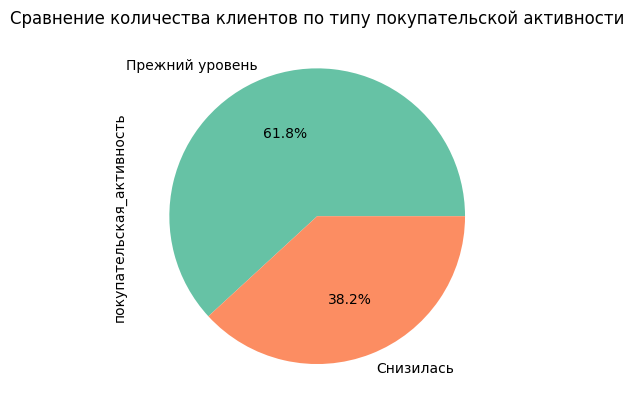

In [31]:
data_market_file_customer['покупательская_активность'].value_counts().plot.pie(colors=sns.color_palette('Set2'),
                                                                               autopct='%1.1f%%');
plt.title('Сравнение количества клиентов по типу покупательской активности');

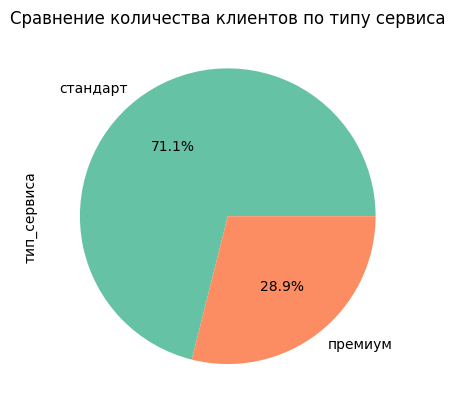

In [32]:
data_market_file_customer['тип_сервиса'].value_counts().plot.pie(colors=sns.color_palette('Set2'), autopct='%1.1f%%');
plt.title('Сравнение количества клиентов по типу сервиса');

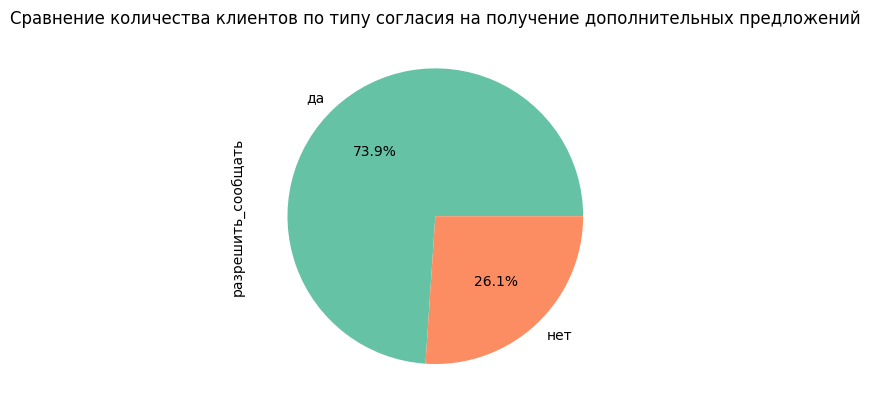

In [33]:
data_market_file_customer['разрешить_сообщать'].value_counts().plot.pie(colors=sns.color_palette('Set2'), autopct='%1.1f%%');
plt.title('Сравнение количества клиентов по типу согласия на получение дополнительных предложений');

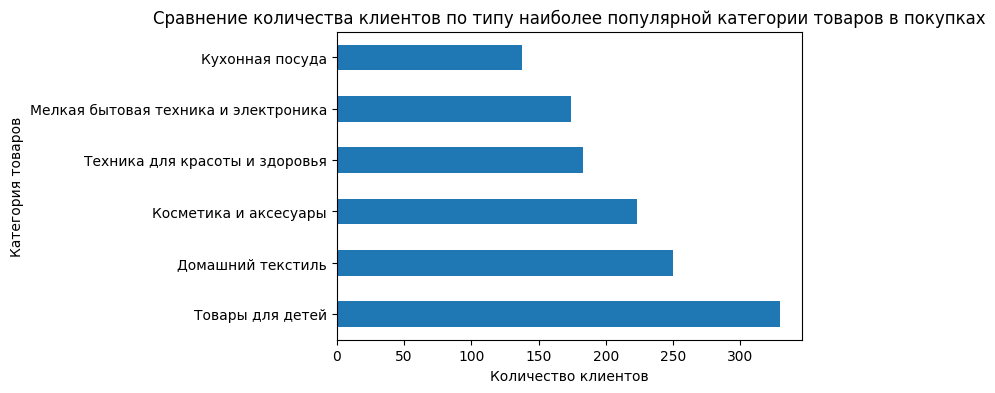

In [34]:
data_market_file_customer['популярная_категория'].value_counts().plot.barh(figsize=(6,4));
plt.title('Сравнение количества клиентов по типу наиболее популярной категории товаров в покупках');
plt.xlabel('Количество клиентов');
plt.ylabel('Категория товаров');

**Краткий вывод по распределению категориальных признаков:**   
- у 62% покупателей активность осталась прежней (или, возможно, выше), а вот у 38% она снизилась. Причем этот параметр указан в общем файле, где нет данных по тратам пользователя в разрезе месяцев. Т.о. если во втором месяце активность пользователя выросла относительно первого месяца, а в третьем снизилась относительно второго - мы можем предположить, что в общем файле такого покупателя отметят как "снизившего покупательскую активность". Это как раз можно будет изучить после обработки финансовых показателей.
- премиум-обслуживаение выбирает менее трети пользователей.
- и четверть клиентов не хочет получить дополнительные предложения. А три четверти - готовы.
- среди популярных категорий в исследуемом массиве данных присутствуют только шесть категорий. Мы не знаем, насколько полно эти категории охватывают ассортимент торговой площадки (в описании заказчика говорится о торговле даже продуктами, но их в этом перечне нет). Если нам захочется укрупнить категории покупателей, то можно попробовать объединить клиентов с лидирующими категориями "Косметика и аксессуары" и "Техника для красоты и здоровья". А также покупателей с категориями "Кухонная посуда", "Домашний текстиль" и "Мелкая бытовая техника и электроника". Категорию "товары для детей" ни с кем объединять не вижу смысла. 

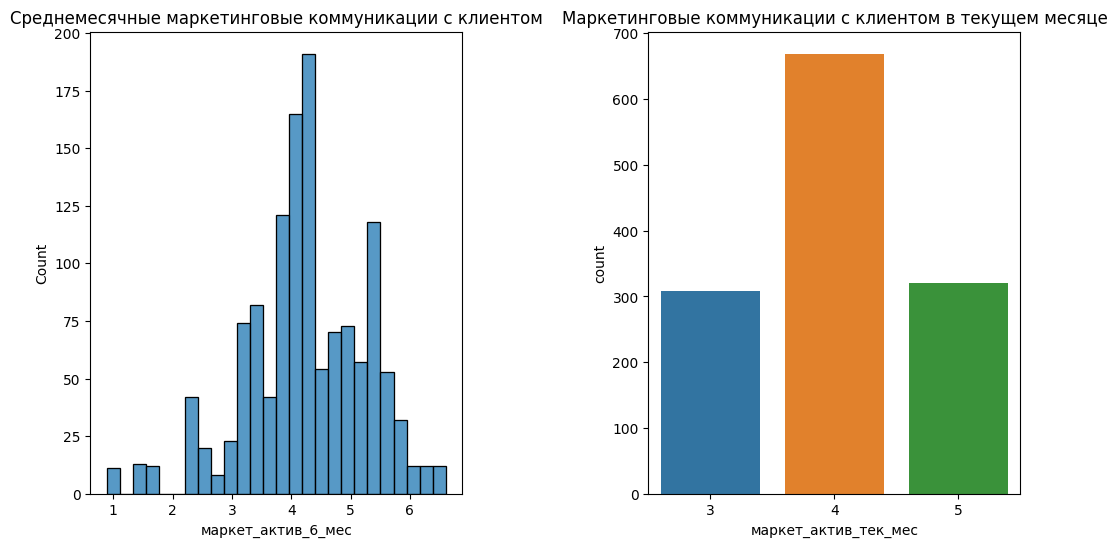

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12,6));
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.subplot(1, 2, 1)
sns.histplot(data=data_market_file_customer, x='маркет_актив_6_мес').set(
    title = 'Cреднемесячные маркетинговые коммуникации с клиентом');
plt.subplot(1, 2, 2)
sns.countplot(data=data_market_file_customer, x='маркет_актив_тек_мес').set(
    title = 'Маркетинговые коммуникации с клиентом в текущем месяце');

В текущем месяце клиенты получили от трех до пяти предложений о покупке. А в гистограмме полугодовой активности, где собраны данные о предложениях в среднем за месяц, есть клиенты, которые получили по 1 предложению в соответствии с этим показателем. Есть предположение, что в этой колонке не учитывается длительность активности клиента - например, значение считается как сумма всех предложений на клиента, деленная на 6, а не на фактическое число месяцев регистрации клиента. Ну, или конкретно в этом месяца было повышено количество предложений на каждого клиента.   
А может быть, наоборот, учитывается. И по одному предложению получили самые недавно зарегистрировавшиеся клиенты.

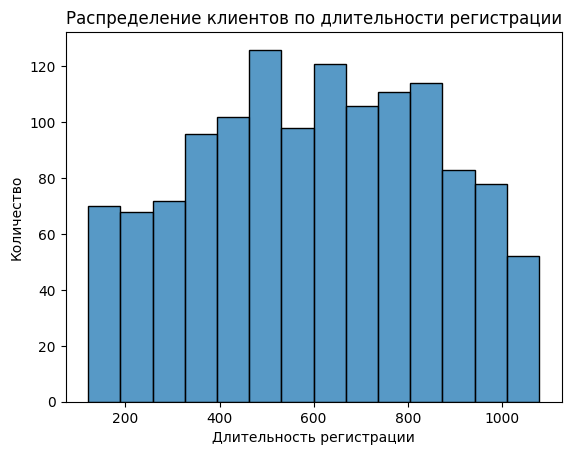

In [36]:
# Сравним параметр "Длительность"

sns.histplot(data=data_market_file_customer, x="длительность");
plt.title('Распределение клиентов по длительности регистрации');
plt.xlabel('Длительность регистрации');
plt.ylabel('Количество');

Все логично, мы сами отобрали клиентов, у которых есть покупки за последние три месяца. Т.е. длительность их регистрации не может быть меньше 180 дней. Что, собственно, мы и видим. Можно будет поделить клиентов на сегменты по длительности их регистрации: "менее 1 года", "от 1 года до 2 лет", "свыше двух лет".

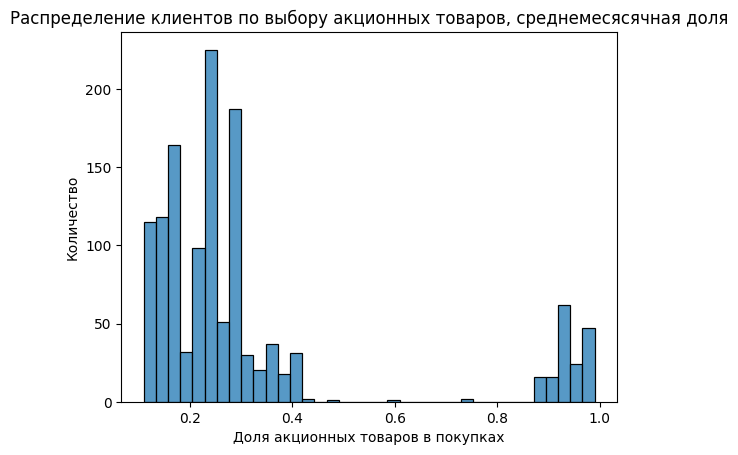

In [37]:
# Сравним параметр "акционные_покупки"

sns.histplot(data=data_market_file_customer, x="акционные_покупки");
plt.title('Распределение клиентов по выбору акционных товаров, среднемесясячная доля');
plt.xlabel('Доля акционных товаров в покупках');
plt.ylabel('Количество');

Вспомним еще раз описание этого параметра: среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев. Не пойму, как она считается. Есть количество покупок за полгода. Есть данные, сколько их них были покупками по акции. Понимаю, как можно рассчитать долю покупок по акции за все полгода. Но как ее посчитать среднемесячно? Просто разделить на количество месяцев регистрации? А так ли посчитано у заказчика?  

У нас есть разделение на два сегмента: клиенты, 85% покупок которых товары по акции. И остальные, которые покупают не более 40% товаров по акции.

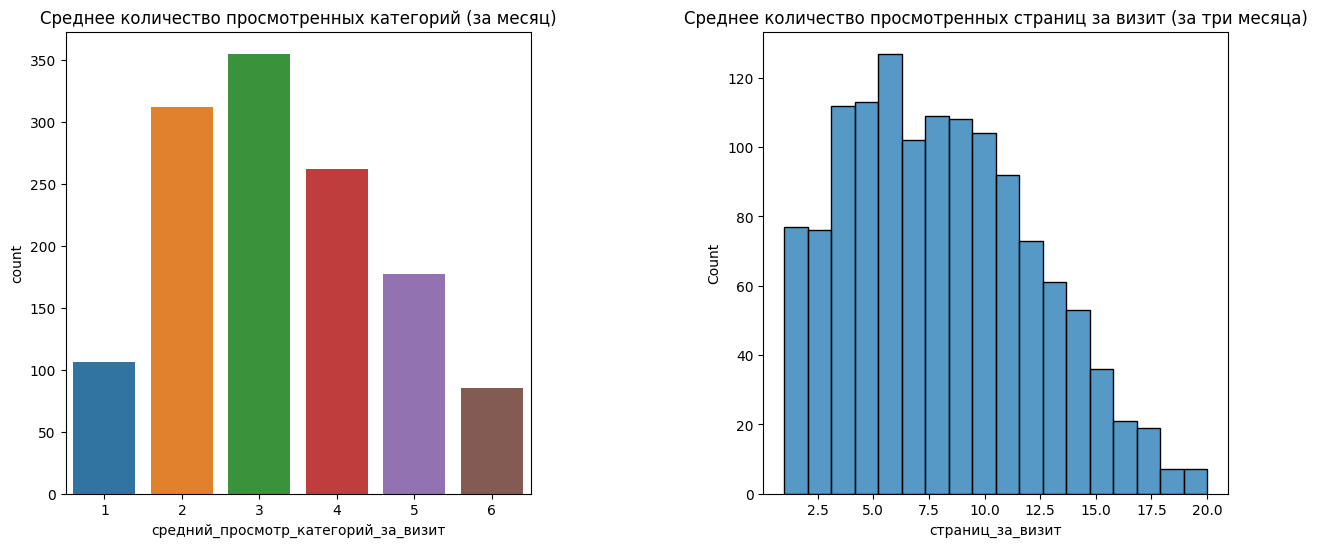

In [38]:
# Сравним параметр "средний_просмотр_категорий_за_визит"

fig, axes = plt.subplots(1, 2, figsize=(15,6));
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.subplot(1, 2, 1)
sns.countplot(data=data_market_file_customer, x='средний_просмотр_категорий_за_визит').set(
    title = 'Cреднее количество просмотренных категорий (за месяц)');
plt.subplot(1, 2, 2)
sns.histplot(data=data_market_file_customer, x='страниц_за_визит').set(
    title = 'Среднее количество просмотренных страниц за визит (за три месяца)');

Распределение похоже на нормальное, с небольшим сдвигом в область меньших величин, никаких особенностей пока не видно.   
Довольно большое количество просмотренных страниц за визит получается - маленький размер страниц? Не слишком эффективный алгоритм поиска товара по запросу? Слишком большой выбор товаров?

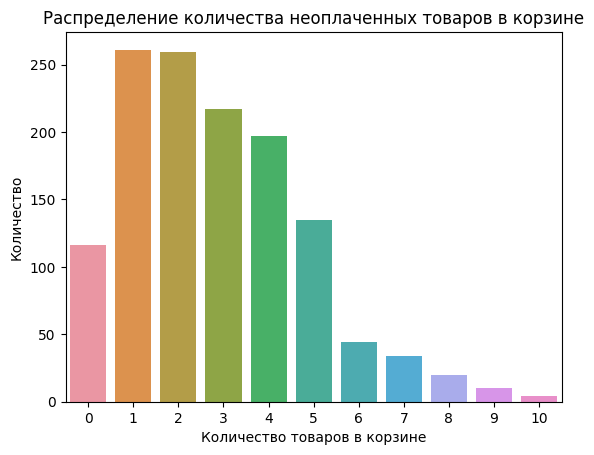

In [39]:
# Сравним параметр "неоплаченные_продукты_штук_квартал"

sns.countplot(data=data_market_file_customer, x="неоплаченные_продукты_штук_квартал");
plt.title('Распределение количества неоплаченных товаров в корзине');
plt.xlabel('Количество товаров в корзине');
plt.ylabel('Количество');

Основная доля товаров в корзине за три месяца находится в интервале от 0 до 5 штук. Желательно уточнить у заказчика, с какой целью клиенты оставляют товары в корзине без внимания. О чем именно нам сообщает этот параметр?

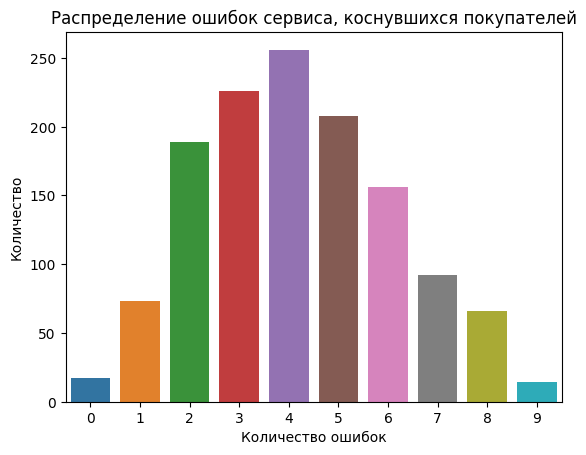

In [40]:
# Сравним параметр "ошибка_сервиса"

sns.countplot(data=data_market_file_customer, x="ошибка_сервиса");
plt.title('Распределение ошибок сервиса, коснувшихся покупателей');
plt.xlabel('Количество ошибок');
plt.ylabel('Количество');

Ситуация с качеством работы сервиса - грустная.

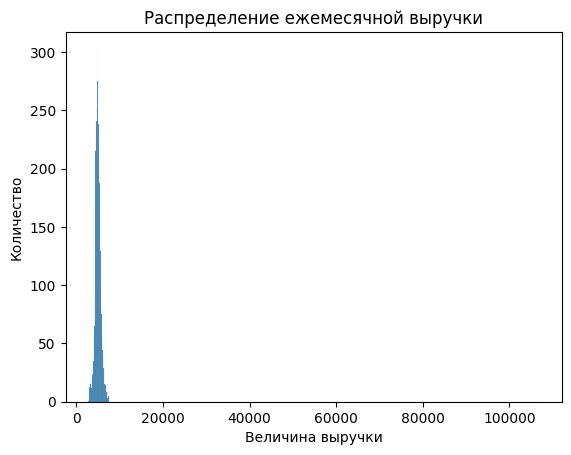

In [41]:
# Сравним параметр "выручка"

sns.histplot(data=data_market_money_customer, x="выручка");
plt.title('Распределение ежемесячной выручки');
plt.xlabel('Величина выручки');
plt.ylabel('Количество');

In [42]:
data_market_money_customer['выручка'].describe()

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: выручка, dtype: float64

Это не совсем выброс в 106 тысяч рублей, но это нетипичный покупатель. Возможно, стоит отбросить эти данные, если количество таких клиентов мало.

In [43]:
# посмотрим, сколько клиентов зафиксированы со столь высоким показателем выручки

print(len(data_market_money_customer.query('выручка > 8000')))
print(len(data_market_money_customer.query('выручка > 7000')))
data_market_money_customer.query('выручка > 8000')

1
35


,id,период,выручка
98,215380,текущий_месяц,106862.2


Можно ограничить данные порогом выручки в 8000 рублей в месяц. Тогда мы исключим эту запись.

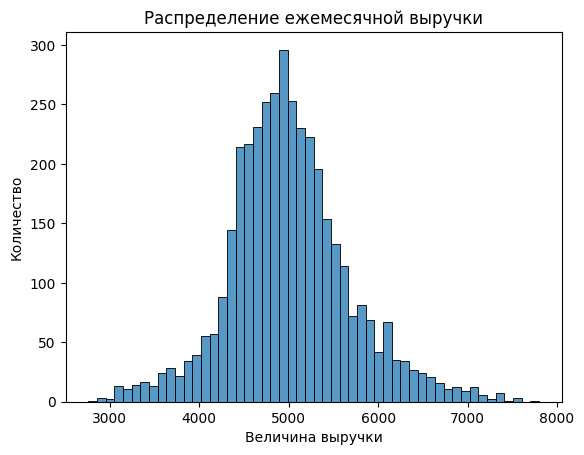

In [44]:
# Сравним еще раз параметр "выручка"

sns.histplot(data=data_market_money_customer.query('выручка < 8000'), x="выручка");
plt.title('Распределение ежемесячной выручки');
plt.xlabel('Величина выручки');
plt.ylabel('Количество');

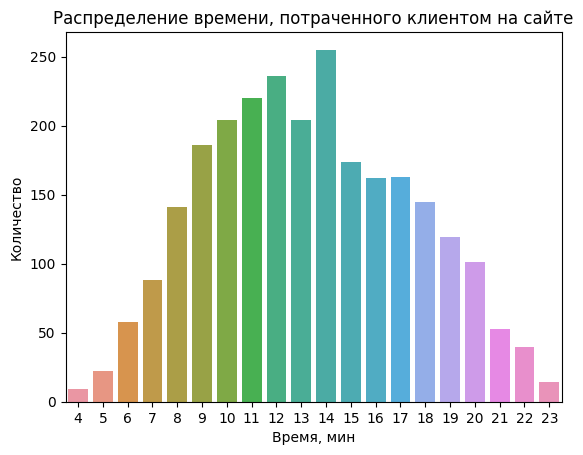

In [45]:
# Сравним параметр "минут"

sns.countplot(data=data_market_time_customer, x="минут");
plt.title('Распределение времени, потраченного клиентом на сайте');
plt.xlabel('Время, мин');
plt.ylabel('Количество');

Интересно получается. В описании данных указано, что время для клиента считается за период. А период составляет один месяц. Т.е. клиент тратит по 12-15 минут в месяц на сайте. При этом за один визит клиент успевает просмотреть по 5-10 страниц магазина. Сколько же раз за месяц клиент заходит в интернет-магазин? Неужели, один? Мы не можем из переданных на анализ данных узнать эту информацию. А если вспомнить, что еще клиент сталкивается и с ошибками сервиса, и все это за 15 минут, то очень насыщенное событие получается.

### Итоговые графики "с усами"

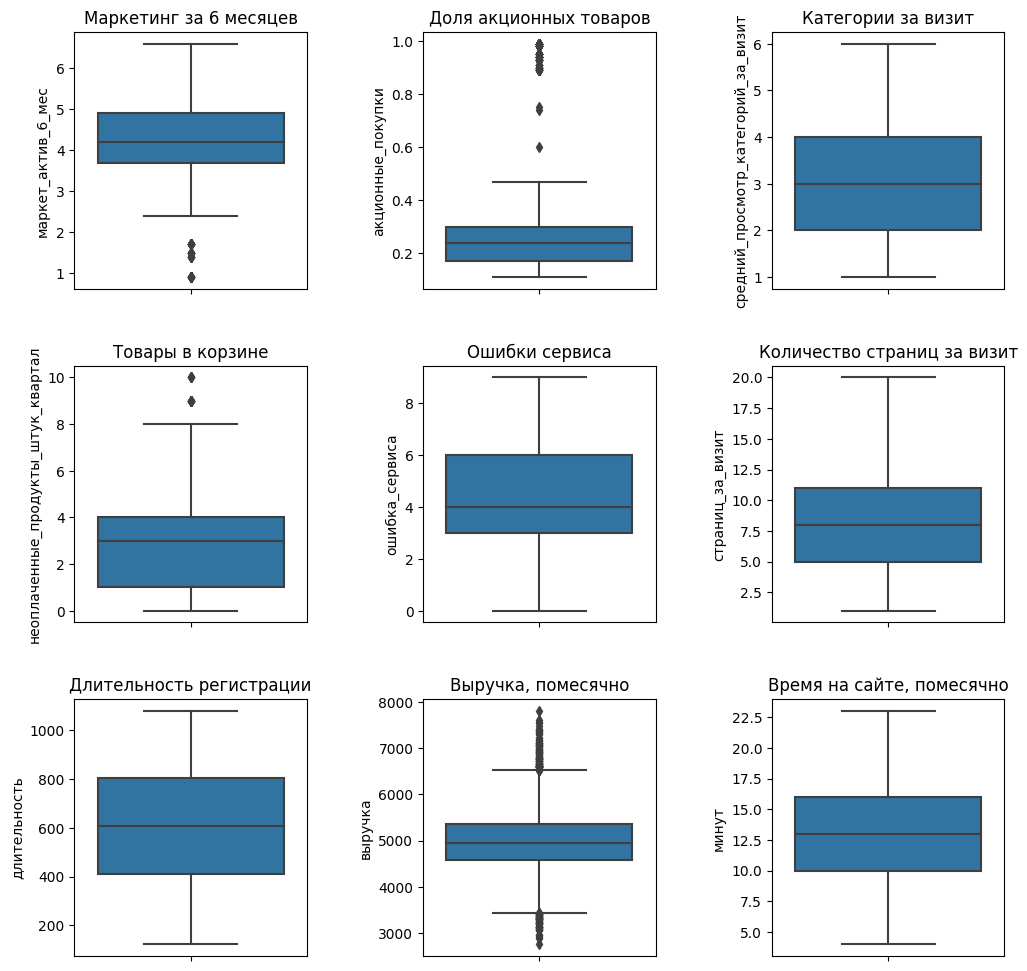

In [46]:
# итоговые графики "с усами"

fig, axes = plt.subplots(3, 3, figsize=(12,12));
plt.subplots_adjust(wspace=0.5, hspace=0.3)
sns.boxplot(data=data_market_file_customer, y='маркет_актив_6_мес', ax=axes[0, 0]).set (
    title='Маркетинг за 6 месяцев');
sns.boxplot(data=data_market_file_customer, y='акционные_покупки', ax=axes[0, 1]).set (
    title='Доля акционных товаров');
sns.boxplot(data=data_market_file_customer, y='средний_просмотр_категорий_за_визит', ax=axes[0, 2]).set (
    title='Категории за визит');
sns.boxplot(data=data_market_file_customer, y='неоплаченные_продукты_штук_квартал', ax=axes[1, 0]).set (
    title='Товары в корзине');
sns.boxplot(data=data_market_file_customer, y='ошибка_сервиса', ax=axes[1, 1]).set (
    title='Ошибки сервиса');
sns.boxplot(data=data_market_file_customer, y='страниц_за_визит', ax=axes[1, 2]).set (
    title='Количество страниц за визит');
sns.boxplot(data=data_market_file_customer, y='длительность', ax=axes[2, 0]).set (
    title='Длительность регистрации');
sns.boxplot(data=data_market_money_customer.query('выручка < 8000'), y='выручка', ax=axes[2, 1]).set (
    title='Выручка, помесячно');
sns.boxplot(data=data_market_time_customer, y='минут', ax=axes[2, 2]).set (
    title='Время на сайте, помесячно');

Большая часть параметров распределена нормально. Часть данных "график с усами" считает выбросами, хотя в гистограммах мы видели иную картину.   
- **Маркетинг за 6 месяцев:** основная часть данных сгруппирована в области 4-5 предложений клиентам за месяц.
- **Доля акционных товаров:** основная часть данных находится в области 20-30% покупок по акции. Но мы помним, что на гистограмме клиенты делились на две большие группы.
- **Категории за визит:** в основном, клиенты просматривают 2-4 категории товаров за один визит на сайт.
- **Товары в корзине:** в основном, клиенты могут оставлять в корзине от 1 до 4 неоплаченных товаров.
- **Ошибки сервиса:** в сновном пользователи сталкиваются с 3-6 ошибками сервиса. Все еще полагаю, что это очень много.
- **Количество страниц за визит:** в среднем клиент успевает просмотреть от 5 до 11 страниц в интернет-магазине.
- **Длительность регистрации:** основная часть клиентов зарегистрирована на сайте от одного года до двух с половиной.
- **Выручка помесячно:** основное количество клиентов тратит в месяц в этом интернет-магазине 4500-5500 рублей.
- **Время на сайте помесячно:** в основном клиент тратит на сайте в месяц от 10 до 16 минут. Это довольно мало времени.

### Объединение данных трех файлов

Чтобы собрать наши данные в общий датафрейм, необходимо сначала разделить данные по выручке и времени каждого клиента из строк по столбцам. Сделаем это с помощью сводных таблиц.

In [47]:
# создадим сводную таблицу из второго файла

data_market_money_customer_pivot = data_market_money_customer.pivot_table(index='id', 
                                                                          columns='период', values='выручка')
data_market_money_customer_pivot

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [48]:
# создадим сводную таблицу из третьего файла

data_market_time_customer_pivot = data_market_time_customer.pivot_table(index='id', 
                                                                        columns='период', values='минут')
data_market_time_customer_pivot

период,предыдущий_месяц,текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [49]:
# создадим общий датафрейм, последовательно добавляя к нему наши сводные таблицы.
# и переименовывая колонки

df_market = data_market_file_customer.merge(data_market_money_customer_pivot, on='id', how='left').rename(
    columns={'предыдущий_месяц':'пред_месяц_выручка', 'препредыдущий_месяц':'предпред_месяц_выручка',
             'текущий_месяц':'текущ_месяц_выручка'})

df_market

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,пред_месяц_выручка,предпред_месяц_выручка,текущ_месяц_выручка
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6


In [50]:
# и добавим второй кусочек

df_market = df_market.merge(data_market_time_customer_pivot, on='id', how='left').rename(
    columns={'предыдущий_месяц':'пред_месяц_время', 'текущий_месяц':'текущ_месяц_время'})


# посмотрим на итог

df_market

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,пред_месяц_выручка,предпред_месяц_выручка,текущ_месяц_выручка,пред_месяц_время,текущ_месяц_время
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [51]:
# проверим на пропуски итоговую таблицу

df_market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
пред_месяц_выручка                     0
предпред_месяц_выручка                 0
текущ_месяц_выручка                    0
пред_месяц_время                       0
текущ_месяц_время                      0
dtype: int64

Ранее мы нашли, что у одного клиента (id=215380) зафиксировано рекордная сумма выручки. Проверим сейчас эту строку и удалим ее.

In [52]:
df_market.loc[df_market['id']==215380]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,пред_месяц_выручка,предпред_месяц_выручка,текущ_месяц_выручка,пред_месяц_время,текущ_месяц_время
29,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,6077.0,5051.0,106862.2,12,14


Это данные за текущий месяц. Тут могла бы быть и техническая ошибка записи данных.  Тем не менее, удалим эту строку из датафрейма.

In [53]:
df_market = df_market.loc[df_market['id']!=215380]
df_market.shape

(1296, 18)

### Добавление параметров в датафрейм

Для последующей задачи сегментации клиентов можно сравнить разницу в ежемесячной выручке между разными месяцами.   
У нас есть данные за три месяца активности. Если мы сравним данные о выручке между "предпредыдущим месяцем" и "предыдущем месяцем", и между "предыдущим месяцем" и "текущим месяцем" (примем допущение, что текущий месяц закончился и более выручка от клиентов не ожидается), то у нас возможны четыре группы:
- **A** - "выручка выросла" и "выручка выросла"
- **B** - "выручка выросла" и "выручка уменьшилась"
- **C** - "выручка уменьшилась" и "выручка выросла"
- **D** - "выручка уменьшилась" и "выручка уменьшилась"

В данном случае, варианты 2 и 3 могут отличаться - так как снижение и рост выручки между периодами могут объясняться результатом маркетинговых действий компании или, например, ошибок сервиса.   
Добавим такую градацию выручки от клиентов.

In [54]:
df_market['d_1'] = df_market['предпред_месяц_выручка'] - df_market['пред_месяц_выручка']
df_market['d_2'] = df_market['пред_месяц_выручка'] - df_market['текущ_месяц_выручка']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
# создадим функцию для категоризации клиентов по разнице в выручке

def categorize_income(df_market):    
    try:
        if ((df_market['d_1'] >= 0) and (df_market['d_2'] >= 0)):
            return 'A'
        elif ((df_market['d_1'] >= 0) and (df_market['d_2'] < 0)):
            return 'B'
        elif ((df_market['d_1'] < 0) and (df_market['d_2'] >= 0)):
            return 'C'
        elif ((df_market['d_1'] < 0) and (df_market['d_2'] < 0)):
            return 'D'
    except:
        return 'E'

In [56]:
# применим функцию в датафрейму и посмотрим, как распределились клиенты

df_market=df_market.reset_index(drop=True)
df_market['группа_клиента'] = df_market.apply(categorize_income, axis=1)
df_market['группа_клиента'].value_counts()

D    576
B    372
A    205
C    143
Name: группа_клиента, dtype: int64

Из 1296 рассматриваемых клиентов у 576 (группа D) наблюдается снижение величины ежемесячной выручки в течение всего периода. У 205 (группа А) наблюдается рост суммы выручки от месяца к месяцу. А у остальных (группы B и C) величина разницы между ежемесячными выручками изменяется то в большую, то в меньшую сторону.

Поскольку мы не ищем высокой линейной зависимости между признаками, нам не нужно преобразовывать существующие параметры в различные степени. Займемся изучением взаимного влияния признаков друг на друга.

### Корреляционный анализ

Уберем колонку с id клиента из датафрейма. Изучим корреляцию признаков через коэффициент Фи.

In [57]:
data_market = df_market.drop(['id'], axis=1)

In [58]:
int_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'пред_месяц_выручка', 'предпред_месяц_выручка',
              'текущ_месяц_выручка', 'пред_месяц_время', 'текущ_месяц_время', 'd_1', 'd_2']

data_market.phik_matrix(interval_cols = int_columns )

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,пред_месяц_выручка,предпред_месяц_выручка,текущ_месяц_выручка,пред_месяц_время,текущ_месяц_время,d_1,d_2,группа_клиента
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.224638,0.497393,0.197213,0.685138,0.576770,0.440798,0.110871,0.299521
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.000000,0.069704,0.124216,0.131814,0.000000,0.033308,0.071728,0.098143
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.080842,0.000000,0.060907,0.038387,0.000000,0.085170,0.023562,0.069141
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.155476,0.315331,0.039795,0.363950,0.330601,0.224523,0.102425,0.123895
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410,0.063881,0.000000,0.000000
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.125572,0.113200,0.147048,0.026448,0.101481,0.176224,0.075895,0.037353
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.060733,0.226381,0.071094,0.262324,0.250558,0.161778,0.000000,0.092254
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.252097,0.043528,0.237240,0.195233,0.089883,0.248469,0.000000,0.413303
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.098440,0.176828,0.092597,0.159837,0.182568,0.130121,0.000000,0.062150
неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.249171,0.261016,0.230022,0.256632,0.232383,0.323722,0.054452,0.136403


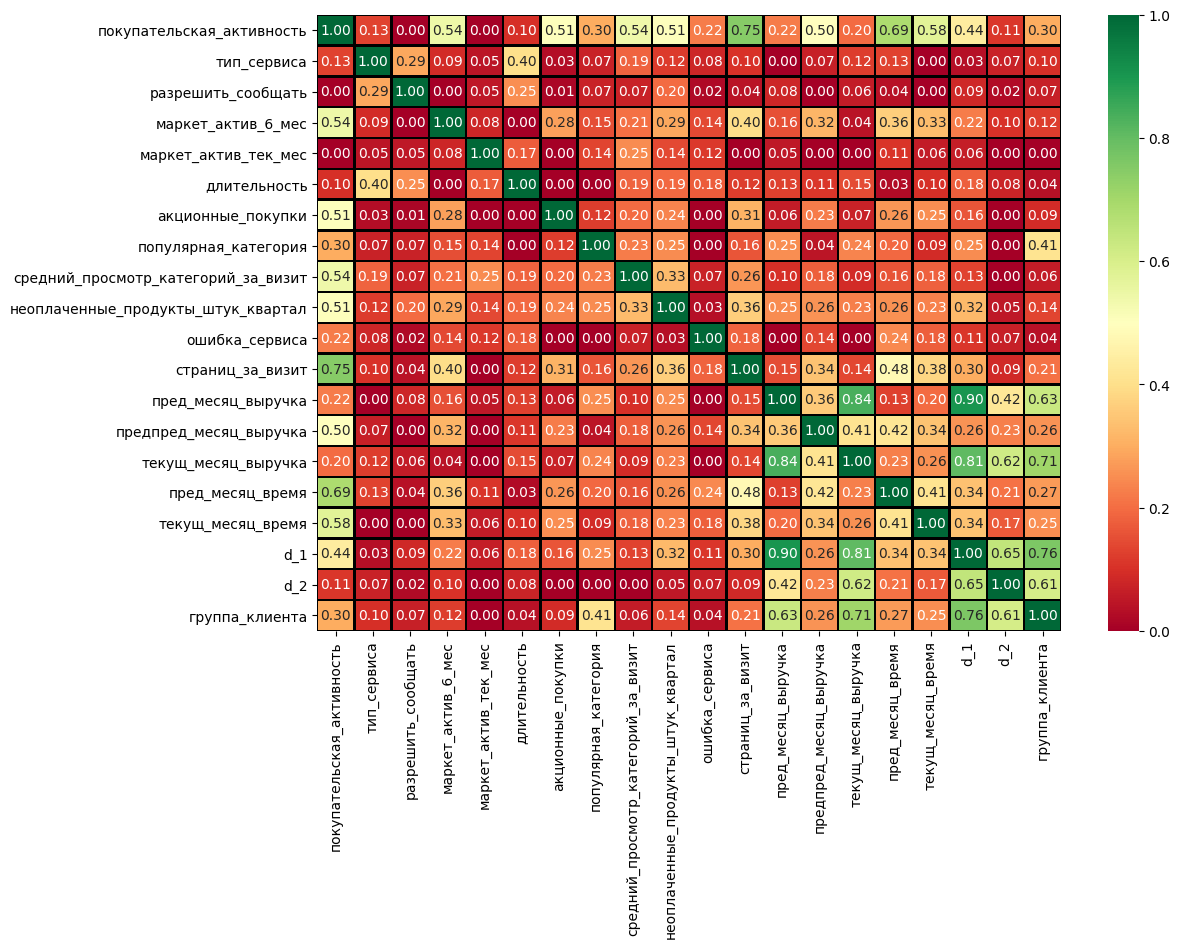

In [59]:
# визуализируем данные

plt.rcParams['figure.figsize'] = [12, 8]
sns.heatmap(data_market.phik_matrix(interval_cols = int_columns),
            annot = True, fmt=".2f", cmap= 'RdYlGn', linewidths=1, linecolor='black');

Наш целевой признак - "покупательская активность".   
Наибольшее влияние на него оказывают следующие параметры: "маркет актив 6 мес", "акционные покупки", "средний просмотр категорий за визит", "неоплаченные продукты штук квартал", "страниц за визит", "предпред месяц выручка", "пред месяц время" и "текущ  месяц время".   
Мультиколлинеарности в данных не отмечено - нет высокой доли зависимости между параметрами, кроме тех, которые мы создали сами - разницы в выручке. Разве что довольно сильно связаны "выручка в текущем месяце" и "выручка в прошлом месяце", но, полагаю, причина в том, что эти параметры просто обладают близкими значениями. Зачастую магазины практикуют использование "минимальной суммы заказа", в связи с чем у нас нет данных о выручке ниже 2500 рублей.

Посмотрим на распределение самых значимых по влиянию друг на друга параметров: мы помним, что "акционные покупки" делились на два кластера.  Из матрицы видно, что на них также оказывает влияние количество просмотренных страниц за визит и выручка за предпредыдущий месяц.

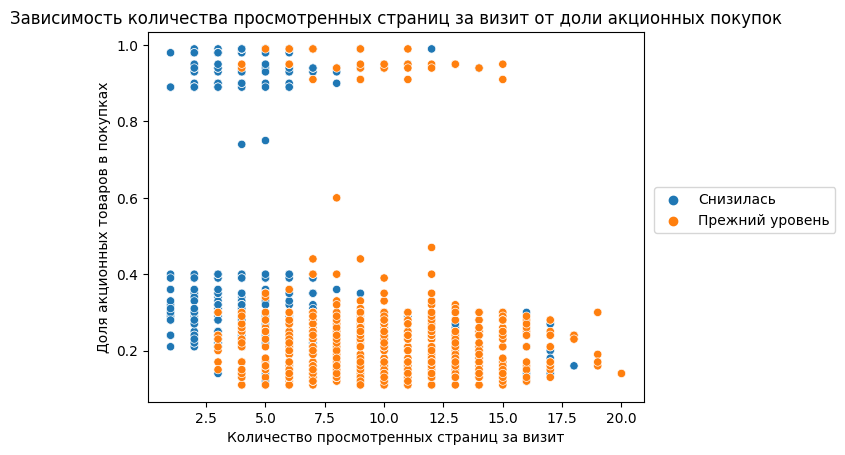

In [60]:
plt.rcdefaults()
sns.scatterplot(data=data_market, x='страниц_за_визит', y='акционные_покупки', hue='покупательская_активность');
plt.title('Зависимость количества просмотренных страниц за визит от доли акционных покупок');
plt.xlabel('Количество просмотренных страниц за визит');
plt.ylabel('Доля акционных товаров в покупках');
plt.legend(bbox_to_anchor=(1.4, 0.6));

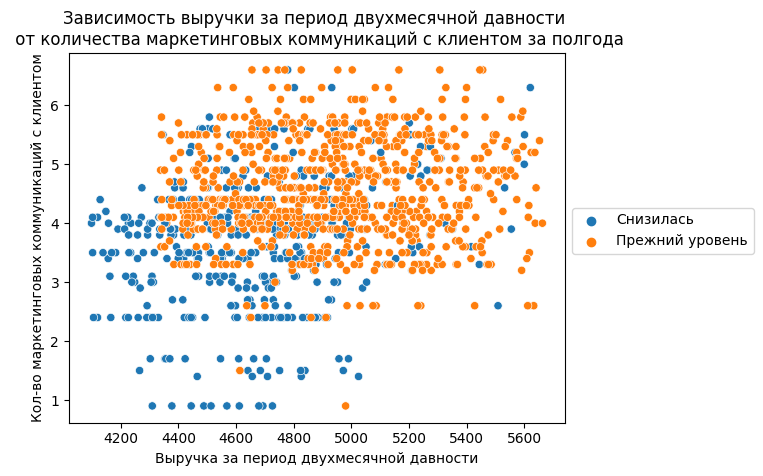

In [61]:
sns.scatterplot(data=data_market, x='предпред_месяц_выручка', y='маркет_актив_6_мес', 
                hue='покупательская_активность');
plt.title('Зависимость выручки за период двухмесячной давности \n от количества \
маркетинговых коммуникаций с клиентом за полгода');
plt.xlabel('Выручка за период двухмесячной давности');
plt.ylabel('Кол-во маркетинговых коммуникаций с клиентом');
plt.legend(bbox_to_anchor=(1, 0.6));

Можно видеть, что у тех покупателей, для которых отмечается снижение покупательской активности, характерно существенно меньшее количество просмотренных страниц, а также меньшая сумма выручки. Также следует отметить, что среди покупателей с прежним уровнем активности практически весь массив данных сосредоточен в области крайне низкой доли акционных товаров в закупках.   
Также можно видеть, что с увеличением количества среднемесячных коммуникаций с клиентом возрастает выручка. Похоже, все эти письма об акциях действительно работают. Как минимум, клиент вспоминает о существовании магазина. А, может быть, эти коммуникации напоминают о товарах, оставленных в корзине и ожидающих оплаты?

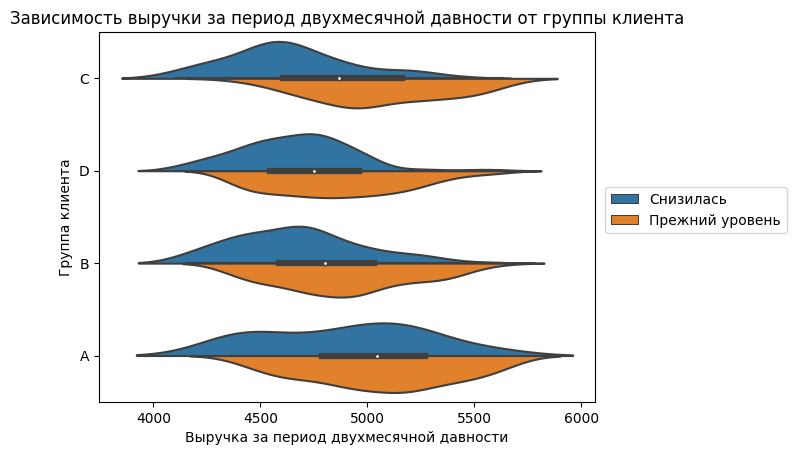

In [62]:
sns.violinplot(data=data_market, x='предпред_месяц_выручка', y='группа_клиента', 
               hue='покупательская_активность', split=True);
plt.title('Зависимость выручки за период двухмесячной давности от группы клиента');
plt.xlabel('Выручка за период двухмесячной давности');
plt.ylabel('Группа клиента');
plt.legend(bbox_to_anchor=(1.4, 0.6));

Интересно, что в группе А (положительная дельта в обоих месяцах) интернет-магазин отмечает снижение покупательской активности. Это означает, что этот параметр определяется не только величиной выручки от клиентов. Впрочем, это видно в матрице корреляции.   
В целом, величины выручки от клиентов группы А находятся в областях выше 5200 рублей, а для других групп медианное значение лежит в области 5000 рублей и ниже. 

Изучим еще корреляцию между группами признаков. Например, сравним влияние категориальных признаков на взаимосвязь между количеством времени, проведенном на сайта за прошлый месяц, и количеством просмотренных страниц.

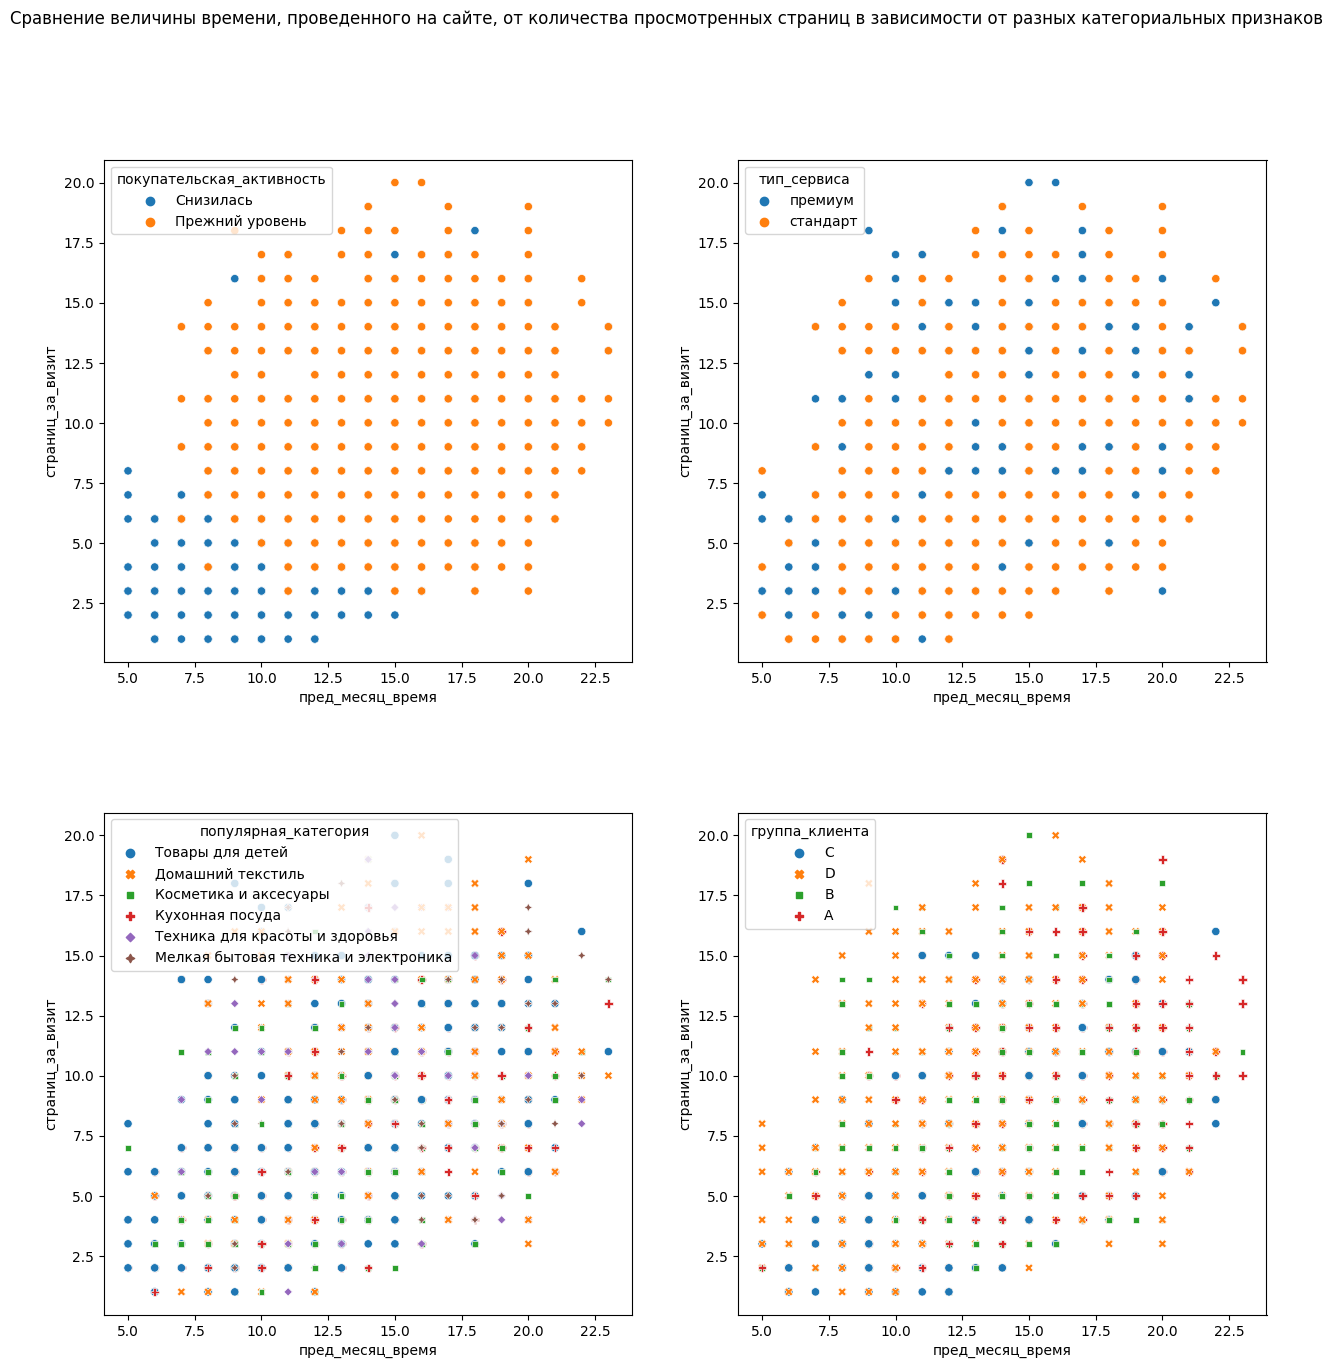

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(15,15));
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.suptitle('Сравнение величины времени, проведенного на сайте, от количества просмотренных страниц в зависимости от разных категориальных признаков')
sns.scatterplot(data=data_market, x='пред_месяц_время', y='страниц_за_визит',
                hue='покупательская_активность', ax=axes[0, 0]);
sns.scatterplot(data=data_market, x='пред_месяц_время', y='страниц_за_визит',
                hue='тип_сервиса', ax=axes[0, 1]);
sns.scatterplot(data=data_market, x='пред_месяц_время', y='страниц_за_визит', 
                hue='популярная_категория', style='популярная_категория', ax=axes[1, 0]);
sns.scatterplot(data=data_market, x='пред_месяц_время', y='страниц_за_визит',
                hue='группа_клиента', style='группа_клиента', ax=axes[1, 1]);

Определенно видна зависимость между снижением покупательской активности и количественными показателями просмотра товаров на сайте (время и страницы). Чем меньше величина времени и количества просмотренных страниц - тем больше вероятность, что клиент теряет интерес к интернет-магазину.   
В то же время есть клиенты, которые успевают за пять минут просмотреть 8 страниц.   
Влияние "типа сервиса" на эти показатели не отмечено.   
Для других категориальных признаков (группы клиента и категории любимых товаров) тоже пока нельзя выявить какой-либо уверенной зависимости.

<Figure size 640x480 with 0 Axes>

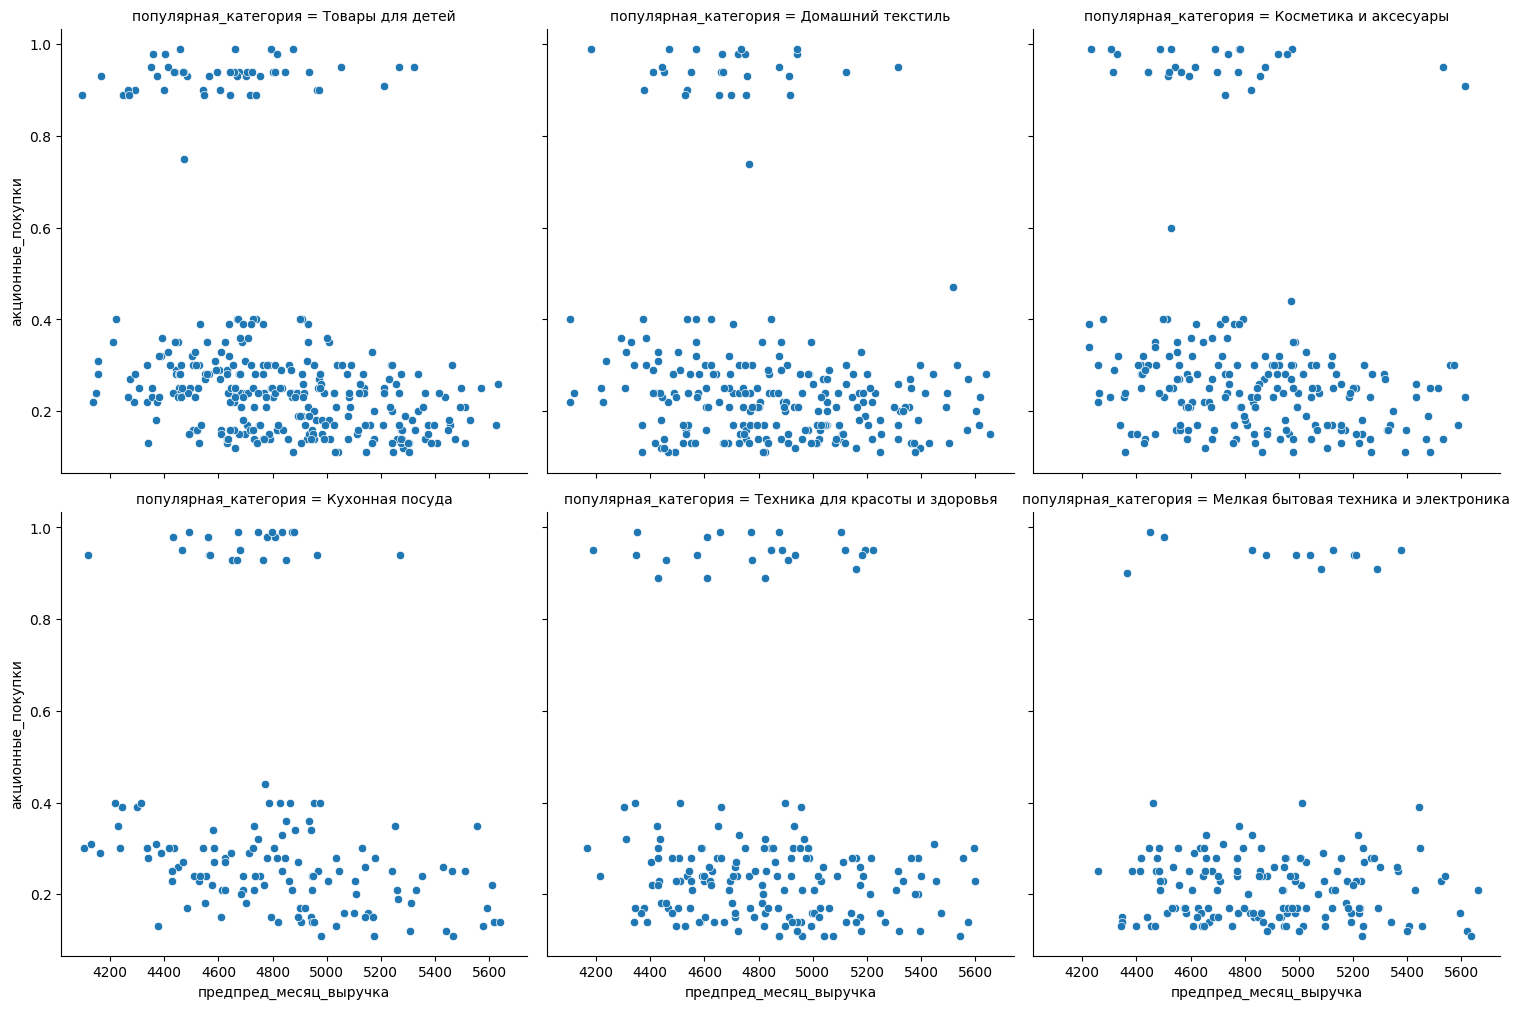

In [64]:
# сравним зависимость выручки за период двухмесячной давности от доли акционных покупок в разрезе группы товаров

plt.subplots_adjust(wspace=0.2, hspace=0.4)

sns.relplot(data=data_market, x='предпред_месяц_выручка', y='акционные_покупки', 
            col='популярная_категория', col_wrap=3);

Можно видеть, что чаще всего по акции покупают "товары для детей". Далее идут "Домашний текстиль", "Косметика и аксессуары" и "Кухонная посуда". А всю технику по акции покупают довольно редко.

**Вывод:** на целевой признак "покупательская активность" наибольшее влияние оказывают признаки, описывающие поведение клиента на сайте, его финансовое и продуктовое поведение - "акционные покупки", "средний просмотр категорий за визит", "неоплаченные продукты штук квартал", "страниц за визит", "предпред месяц выручка", "пред месяц время" и "текущ  месяц время". Из группы признаков, описывающих коммуникацию с клиентом, влияние оказывает только признак "маркет актив 6 мес".   

## Построение модели

### Подготовка данных

Обучим и проверим четыре варианта моделей машинного обучения для поиска решения задачи клиента. Это будут модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC().    Создадим пайплайн, состоящий из этапов подготовки категориальных и количественных данных, обучения моделей, оценки их качества с помощью метрики ROC_AUC. Метрика ROC_AUC является наиболее общей и независимой оценкой эффективности модели. Она равна площади под кривой ROC, которая, в свою очередь, показывает зависимость между TPR и FRP — промежуточными метриками, которые оценивают число верно классифицированных объектов класса 1 и неверно классифицированных объектов класса 0. Идеальная модель имеет величину ROC_AUC равную 1.

В данных у нас остались категориальные данные "тип_сервиса", "разрешить_сообщать", "популярная_категория" и "группа клиента". Остальные параметры являются количественными.

In [65]:
# задаем константы

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [66]:
# делим данные на выборки

X_train, X_test, y_train, y_test = train_test_split(
    data_market.drop(
        ['покупательская_активность'],axis=1),
    data_market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_market['покупательская_активность']
)

In [67]:
# создаем списки с названиями признаков

ohe_columns = ['разрешить_сообщать', 'популярная_категория']

ord_columns = ['тип_сервиса', 'группа_клиента']

num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'пред_месяц_выручка', 'предпред_месяц_выручка',
              'текущ_месяц_выручка', 'пред_месяц_время', 'текущ_месяц_время', 'd_1', 'd_2']

In [68]:
# создаем пайплайн для подготовки данных

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))])

ord_pipe = Pipeline([('ord', OrdinalEncoder(categories=[
    ['стандарт', 'премиум'],
    ['D', 'C', 'B', 'A'],
], handle_unknown = 'use_encoded_value', 
    unknown_value = np.nan
))])


data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', [StandardScaler(), MinMaxScaler()], num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Поиск оптимальной модели

Воспользуемся подбором параметров с помощью GridSearch

In [69]:
# задаем параметры перебора моделей и их гиперпараметров

param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['rbf','sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
]

In [70]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                       

In [71]:
# посмотрим на итоги проверки моделей

pd.set_option('display.max_colwidth', None)
model_rank = pd.DataFrame(grid.cv_results_)
display(model_rank[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
57,1,SVC(random_state=42),0.913468,"{'models': SVC(random_state=42), 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}"
58,2,SVC(random_state=42),0.906593,"{'models': SVC(random_state=42), 'models__kernel': 'rbf', 'preprocessor__num': MinMaxScaler()}"
64,3,SVC(random_state=42),0.897299,"{'models': SVC(random_state=42), 'models__kernel': 'poly', 'preprocessor__num': MinMaxScaler()}"
46,4,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.897263,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1, 'preprocessor__num': MinMaxScaler()}"
49,5,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.895986,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 2, 'preprocessor__num': MinMaxScaler()}"
...,...,...,...,...
5,62,DecisionTreeClassifier(random_state=42),0.743533,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': 'passthrough'}"
4,62,DecisionTreeClassifier(random_state=42),0.743533,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': MinMaxScaler()}"
3,62,DecisionTreeClassifier(random_state=42),0.743533,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': StandardScaler()}"
61,65,SVC(random_state=42),0.621651,"{'models': SVC(random_state=42), 'models__kernel': 'sigmoid', 'preprocessor__num': MinMaxScaler()}"


**Вывод:** наивысший результат метрики ROC_AUC (0.913) получен на модели по методу опорных векторов - {'models': SVC(random_state=42), 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}.   
Именно эти параметры мы будем использовать для предсказания типа пользовательской активности.

### Анализ важности признаков

In [72]:
# инициализируем нашу лучшую модель

model_best = SVC(random_state=RANDOM_STATE, probability=True)


# объявляем кодировщики

encoder_bm = OneHotEncoder(drop='first', sparse=False)
ord_bm = OrdinalEncoder(categories=[
                        ['стандарт', 'премиум'],
                        ['D', 'C', 'B', 'A'],
                        ], handle_unknown = 'use_encoded_value', 
                        unknown_value = np.nan)

scaler_bm = StandardScaler()
label_bm = LabelEncoder()


# произведем кодирование

X_train_ohe_bm = encoder_bm.fit_transform(X_train[ohe_columns])
X_test_ohe_bm = encoder_bm.transform(X_test[ohe_columns])
encoder_col_names = encoder_bm.get_feature_names()

X_train_ord_bm = ord_bm.fit_transform(X_train[ord_columns])
X_test_ord_bm = ord_bm.transform(X_test[ord_columns])

y_train = label_bm.fit_transform(y_train)
y_test = label_bm.transform(y_test)
print(label_bm.classes_)


# проверяю, что все получилось

encoder_col_names

['Прежний уровень' 'Снизилась']


array(['x0_нет', 'x1_Косметика и аксесуары', 'x1_Кухонная посуда',
       'x1_Мелкая бытовая техника и электроника',
       'x1_Техника для красоты и здоровья', 'x1_Товары для детей'],
      dtype=object)

In [73]:
# Произведем стандартизацию

scaler_bm.fit(X_train[num_columns])
X_train_scaled_bm = scaler_bm.transform(X_train[num_columns])

X_test_scaled_bm = scaler_bm.transform(X_test[num_columns])

In [74]:
# соберем все преобразованные данные и обучим модель на них

X_train_ohe_bm = pd.DataFrame(X_train_ohe_bm, columns=encoder_col_names)
X_test_ohe_bm = pd.DataFrame(X_test_ohe_bm, columns=encoder_col_names)

X_train_ord_bm = pd.DataFrame(X_train_ord_bm, columns=ord_columns)
X_test_ord_bm = pd.DataFrame(X_test_ord_bm, columns=ord_columns)

X_train_scaled_bm = pd.DataFrame(X_train_scaled_bm, columns=num_columns)
X_test_scaled_bm = pd.DataFrame(X_test_scaled_bm, columns=num_columns)

X_train_bm = pd.concat([X_train_ohe_bm, X_train_ord_bm, X_train_scaled_bm], axis=1)
X_test_bm = pd.concat([X_test_ohe_bm, X_test_ord_bm, X_test_scaled_bm], axis=1)

model_best.fit(X_train_bm, y_train)

SVC(probability=True, random_state=42)

In [75]:
# используем визуализацию с помощью shap 

explainer = shap.Explainer(model_best.predict_proba, X_test_bm)
shap_values = explainer(X_test_bm)

PermutationExplainer explainer: 325it [06:26,  1.21s/it]                         


In [76]:
shap_values.shape

(324, 23, 2)

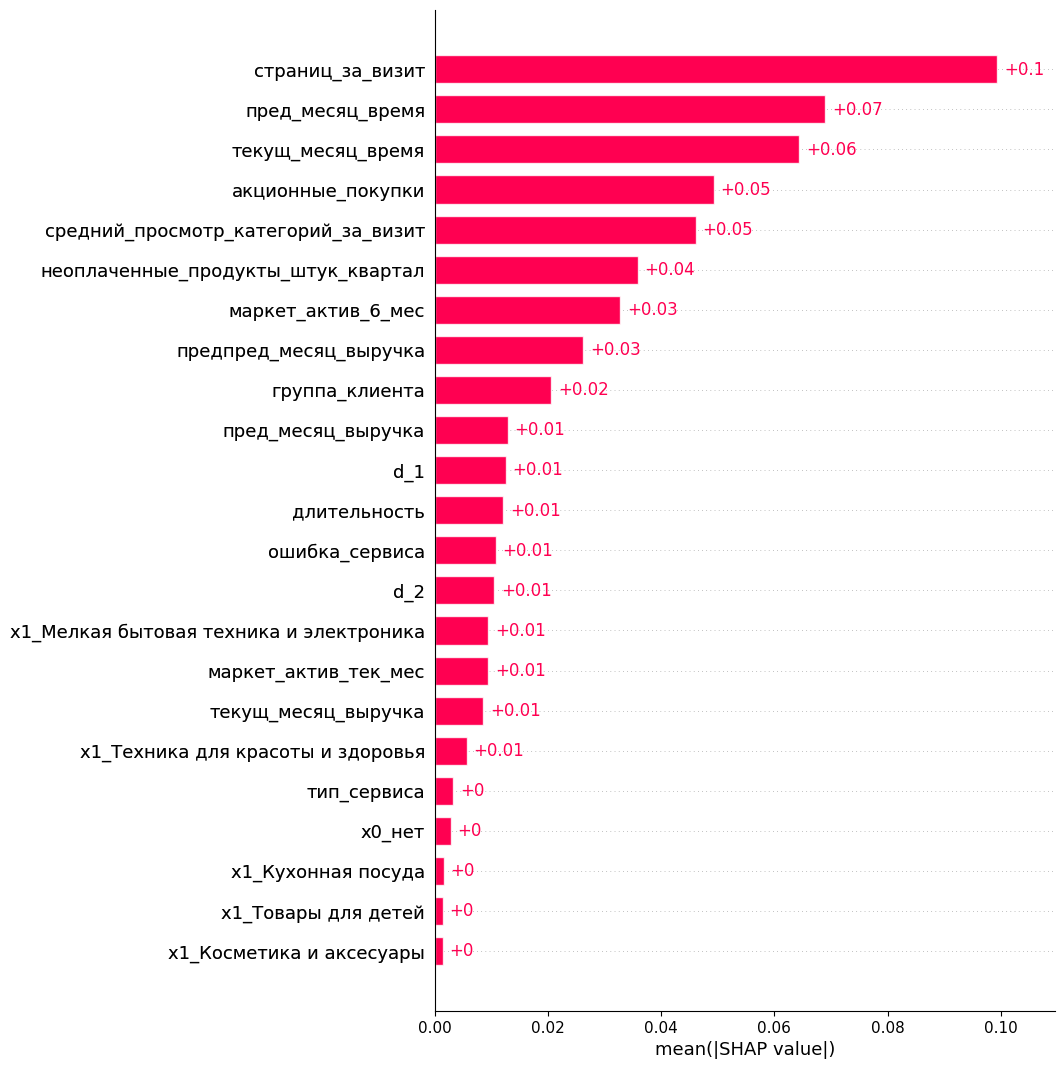

In [77]:
# оценим общую важность признаков для модели

shap.plots.bar(shap_values[:, :, 1], max_display=25)

Абсолютные значения признаков не столь впечатляющи.   
Мы видим, что наибольший эффект на модель оказывает признак "количество страниц за визит". Далее, примерно одинаково, влияют "время, проведенное на сайте за прошлый" и "за текущий месяц". Далее идут признаки "соотношение акционных покупок" и "средний просмотр категорий за визит". Еще к значимым признакам можно отнести "оставленные в корзине товары", "маркетинговая активность по отношению к клиенту за полгода" и "выручка за предпредыдущий месяц". Все остальные признаки вносят менее значимый вклад в принятие решения моделью.   
**Можно видеть, что все значимые признаки объединяет одно - они описывают время и эффективность взаимодействия с сайтом и продуктами.**

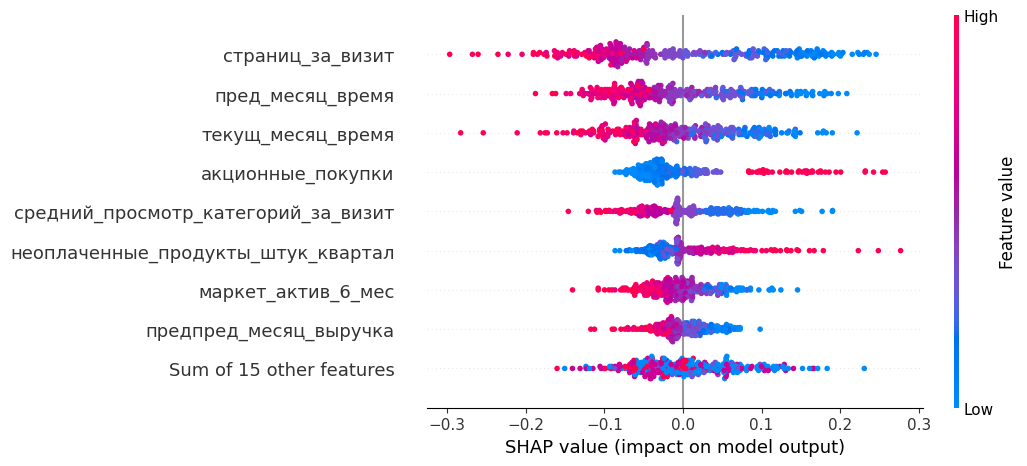

In [78]:
# построим график со значениями

shap.plots.beeswarm(shap_values[:, :, 1], max_display=9)

Признаки отображаются в порядке уменьшения значимости.   
Класс ноль - это "покупательская активность осталась прежней". Класс единица - "покупательская активность снизилась".   
Высокие значения просмотренных страниц за визит и проведенного на сайте времени уменьшают вероятность отнесения клиента к категории "снизивших активность" покупателей. А для признаков "акционные покупки" и "товары в корзине" ситуация обратная - чем выше значение этих параметров, тем выше вероятность, что клиент станет меньше покупать в интернет-магазине.

С помощью визуализации SHAP-графиков типа waterfall позволяет изучить значимость параметров, которые модель присвоила данным. Сравним пару значений.

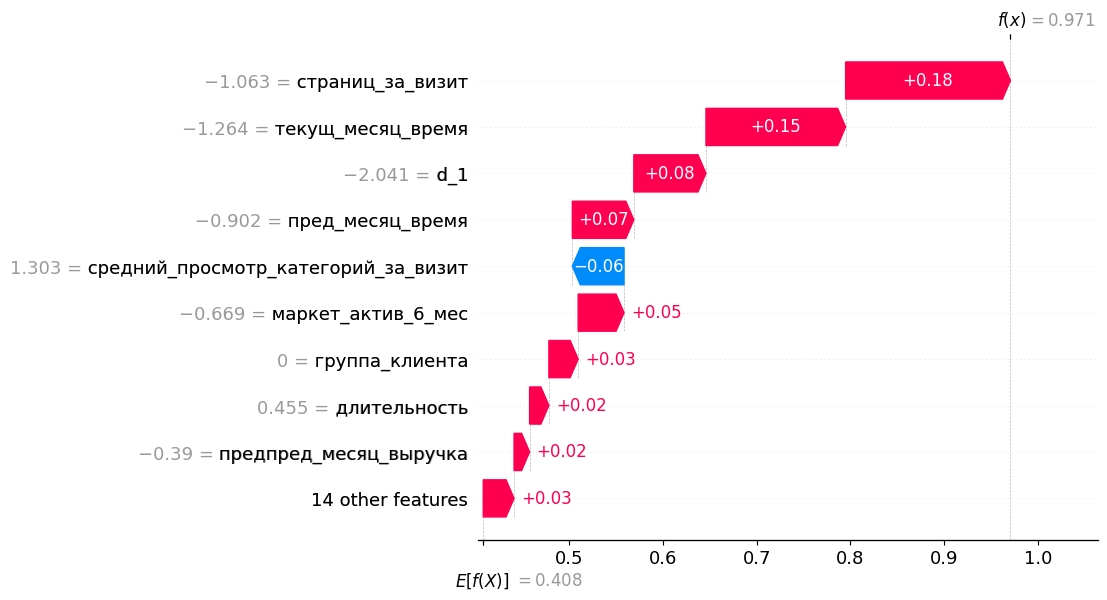

In [79]:
shap.plots.waterfall(shap_values[181, :, 1]) 

In [80]:
X_test_bm['y_test'] = y_test.tolist()
X_test_bm['y_test'].loc[181]

1

Целевой признак принял значение "снизилась" - и действительно: у клиента снизилось количество просмотренных страниц за визит, время, проведенное за сайте за два месяца, снизилась выручка от клиента между периодами двухмесячной давности и месячной давности.

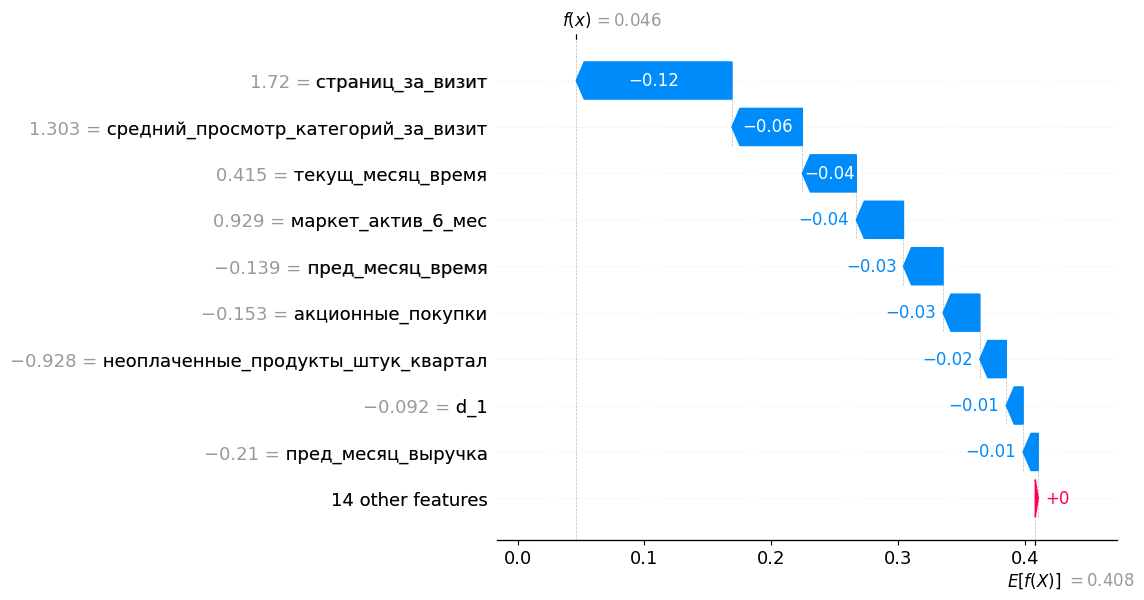

In [81]:
shap.plots.waterfall(shap_values[15, :, 1]) 

In [82]:
X_test_bm['y_test'].loc[15]

0

Целевой признак принял значение "прежний уровень" - все параметры указывают на это, увеличение времени, проведенном на сайте, увеличение количества просмотренных категорий, уменьшение товаров, купленных по акции.

**Вывод:** для предказания показателя "покупательской активности" сформирована модель, основанная на методе опорных векторов. Эффективность модели по метрике ROC_AUC составляет 0,913, что является весьма высоким значением.   
В своих выводах модель опирается на такие параметры как "количество страниц за визит", "время, проведенное на сайте за прошлый месяц", "время проведенной на сайте за текущий месяц". Далее по уменьшению значимости идут признаки "соотношение акционных покупок" и "среднее количество просмотренных категорий за визит", "оставленные в корзине товары", "маркетинговая активность по отношению к клиенту за полгода" и "выручка за предпредыдущий месяц".   
Следует отметить, что среднее время на сайте за месяц составляет всего лишь 12-15 минут, что кажется довольно низким показателем. При этом за визит просматривается порядка 7-10 страниц. Около одной минуты на страницу и остаток - на оформление покупки. Это тоже кажется довольно низким показателем. Покупки совершаются очень быстро, желательно разобраться, в чем может быть причина такого поведения. Возможно, у магазина невысокий ассортимент товаров? Или у товара так мало сопроводительной информации, что на ее изучение не тратится время? В текущей системе оценки покупательской активности - время и разнообразие просматриваемых клиентом страниц - это ключевые параметры, которые нужно увеличивать.

## Сегментация покупателей

### Объединение и изучение данных

Для сегментации покупателей предлагается воспользоваться результатами моделирования и данными из четвертого файла `money.csv`. Вспомним еще раз, что находится в этом файле.

In [83]:
print(data_money_customer.shape)
data_money_customer.head()

(1297, 2)


,id,прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


В этом файле у нас находятся id клиентов и некая абстрактная величина, характеризующая "прибыль" от клиента. Объединим наш итоговый файл и этот.

In [84]:
data_market_full = df_market.merge(data_money_customer, on='id', how='left')
data_market_full.shape

(1296, 22)

In [85]:
data_market_full.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,страниц_за_визит,пред_месяц_выручка,предпред_месяц_выручка,текущ_месяц_выручка,пред_месяц_время,текущ_месяц_время,d_1,d_2,группа_клиента,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,5,5216.0,4472.0,4971.6,12,10,-744.0,244.4,C,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,5,5457.5,4826.0,5058.4,8,13,-631.5,399.1,C,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,4,6158.0,4793.0,6610.4,11,13,-1365.0,-452.4,D,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,2,5807.5,4594.0,5872.5,8,11,-1213.5,-65.0,D,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,4,4738.5,5124.0,5388.5,10,10,385.5,-650.0,B,3.95


In [86]:
# проверим на пропуски
data_market_full.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
пред_месяц_выручка                     0
предпред_месяц_выручка                 0
текущ_месяц_выручка                    0
пред_месяц_время                       0
текущ_месяц_время                      0
d_1                                    0
d_2                                    0
группа_клиента                         0
прибыль                                0
dtype: int64

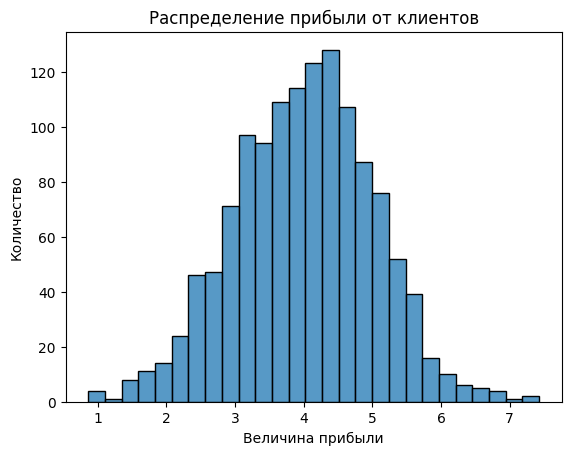

In [87]:
# Изучим распределение значений параметра "прибыль"

sns.histplot(data=data_market_full, x="прибыль");
plt.title('Распределение прибыли от клиентов');
plt.xlabel('Величина прибыли');
plt.ylabel('Количество');

Мы видим колокол нормального распределения параметра. Изучим влияние на него различных параметров из основного файла данных.

In [88]:
# посмотрим, есть ли линейная зависимость между "прибылью" и другими параметрами

int_columns_2 = ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
                 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
                 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
                 'пред_месяц_выручка', 'предпред_месяц_выручка', 'текущ_месяц_выручка', 
                 'пред_месяц_время', 'текущ_месяц_время', 'd_1', 'd_2', 'прибыль']

data_market_full.phik_matrix(interval_cols = int_columns_2)['прибыль'].sort_values(ascending=False)

прибыль                                1.000000
предпред_месяц_выручка                 0.159543
пред_месяц_выручка                     0.132826
d_1                                    0.116008
маркет_актив_тек_мес                   0.095359
текущ_месяц_выручка                    0.090209
id                                     0.084901
ошибка_сервиса                         0.081366
популярная_категория                   0.069684
группа_клиента                         0.052607
разрешить_сообщать                     0.034982
d_2                                    0.033456
средний_просмотр_категорий_за_визит    0.021214
акционные_покупки                      0.000000
неоплаченные_продукты_штук_квартал     0.000000
покупательская_активность              0.000000
страниц_за_визит                       0.000000
длительность                           0.000000
маркет_актив_6_мес                     0.000000
пред_месяц_время                       0.000000
текущ_месяц_время                      0

Есть незначительная корреляция между "прибылью" и "выручкой за прошлый" и за "позапрошлый" месяцы, а также от разницы между этими значениями.   
Визуализируем это с помощью нескольких графиков.

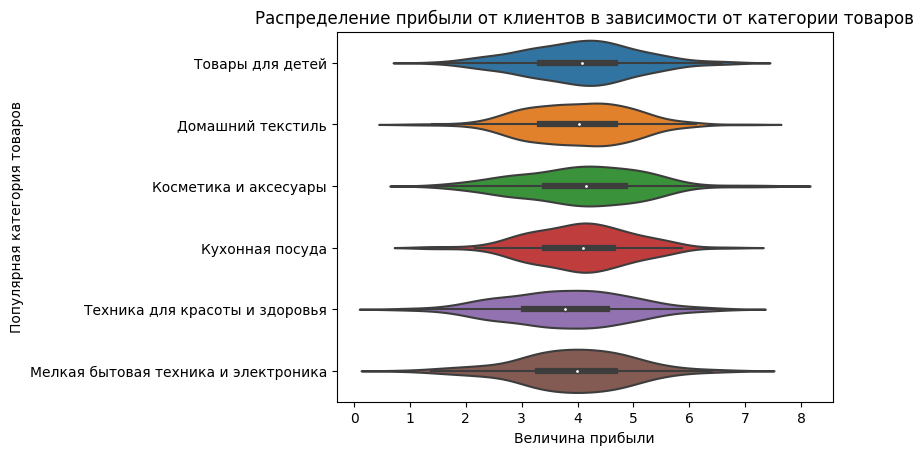

In [89]:
sns.violinplot(data=data_market_full, x='прибыль', y='популярная_категория');
plt.title('Распределение прибыли от клиентов в зависимости от категории товаров');
plt.xlabel('Величина прибыли');
plt.ylabel('Популярная категория товаров');

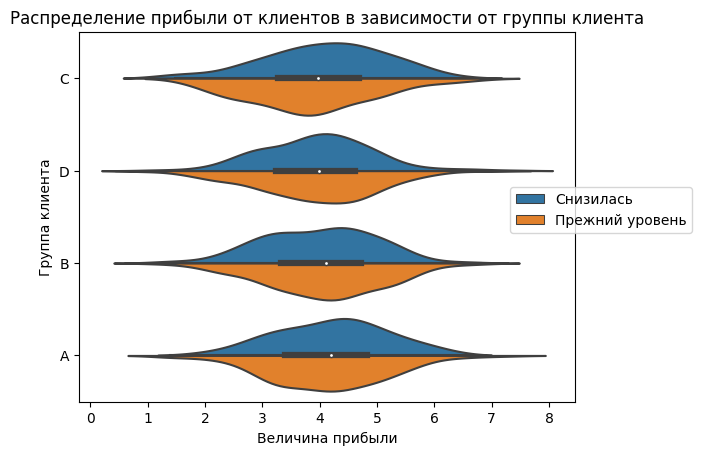

In [90]:
sns.violinplot(data=data_market_full, x="прибыль", y="группа_клиента", hue="покупательская_активность", split=True);
plt.title('Распределение прибыли от клиентов в зависимости от группы клиента');
plt.xlabel('Величина прибыли');
plt.ylabel('Группа клиента');
plt.legend(bbox_to_anchor=(1.25, 0.6));

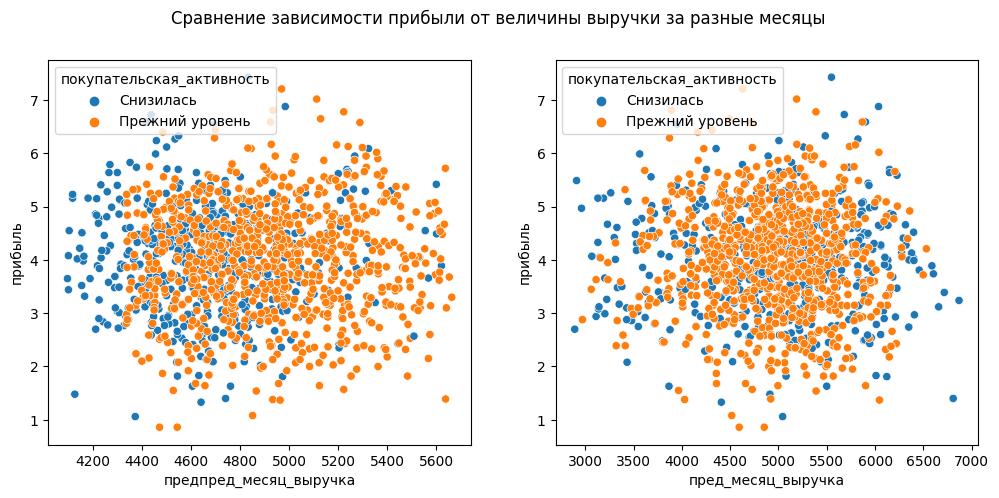

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12,5));
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.suptitle('Сравнение зависимости прибыли от величины выручки за разные месяцы')
sns.scatterplot(data=data_market_full, x='предпред_месяц_выручка', y='прибыль',
                hue='покупательская_активность', ax=axes[0]);
sns.scatterplot(data=data_market_full, x='пред_месяц_выручка', y='прибыль',
                hue='покупательская_активность', ax=axes[1]);

А визуально эта зависимость и не видна. Зато видно, что в сравнении с позапрошлым месяцем уменьшился нижний порог выручки и вырос верхний порог. Если два месяца назад значения находились в пределах от 4000 до 5800 рублей, то в прошлом месяцы интервал изменился до 2800-7000 рублей. Снижение нижней границы выручки может быть связано в изменением нижнего порога стоимости заказа в интернет-магазине (хотя у нас все еще нет достоверных данных о том, что он вообще существует).

### Разделение клиентов на сегменты

Изучая данные, мы видели, что клиенты разделяются на подгруппы по следующим направлениям:   
- **по доле акционных товаров в закупках** - те, кто покупает практически только по акции, и те, кто изредка покупает товары по акции среди прочих товаров;
- **по популярной категории товаров** - можно объединить покупателей в три подгруппы:
    - *покупающие товары для красоты* - "косметика и аксессуары" и "техника для красоты и здоровья"
    - *покупающие товары для дома* - "домашний текстиль", "кухонная посуда" и "мелкая бытовая техника и электроника"
    - *покупающие товары для детей* - "товары для детей"

Применим оба типа фильтрации для выделения шести сегментов покупателей.

In [92]:
# Сегмент "Товары для красоты по акции"

beauty_sale = data_market_full.query('популярная_категория in ["Косметика и аксесуары", \
                                    "Техника для красоты и здоровья"] and акционные_покупки > 0.6')
beauty_sale.shape

(53, 22)

In [93]:
# Сегмент "Товары для красоты без акции"

beauty_non_sale = data_market_full.query('популярная_категория in ["Косметика и аксесуары", \
                                        "Техника для красоты и здоровья"] and акционные_покупки < 0.6')
beauty_non_sale.shape

(351, 22)

In [94]:
# Сегмент "Товары для дома по акции"

home_sale = data_market_full.query('популярная_категория in ["Домашний текстиль", \
                                    "Мелкая бытовая техника и электроника", "Кухонная посуда"] \
                                    and акционные_покупки > 0.6')
home_sale.shape

(64, 22)

In [95]:
# Сегмент "Товары для дома без акции"

home_non_sale = data_market_full.query('популярная_категория in ["Домашний текстиль", \
                                        "Мелкая бытовая техника и электроника", "Кухонная посуда"] \
                                        and акционные_покупки < 0.6')
home_non_sale.shape

(498, 22)

In [96]:
# Сегмент "Товары для детей по акции"

child_sale = data_market_full.query('популярная_категория == "Товары для детей" and акционные_покупки > 0.6')
child_sale.shape

(49, 22)

In [97]:
# Сегмент "Товары для детей без акции"

child_non_sale = data_market_full.query('популярная_категория == "Товары для детей" and акционные_покупки < 0.6')
child_non_sale.shape

(280, 22)

Вполне очевидно, что количество клиентов, которые покупают товары исключительно по акции, гораздо меньше, чем количество клиентов, просто осуществляющих покупки в интернет-магазине. И большая часть клиентов, для которых отмечается снижение покупательской активности, предпочитали совершать покупки только акционных товаров.

### Изучение сегмента "Товары для красоты по акции"

Посмотрим, чем характеризуются клиенты сегменте "Товары для красоты по акции".

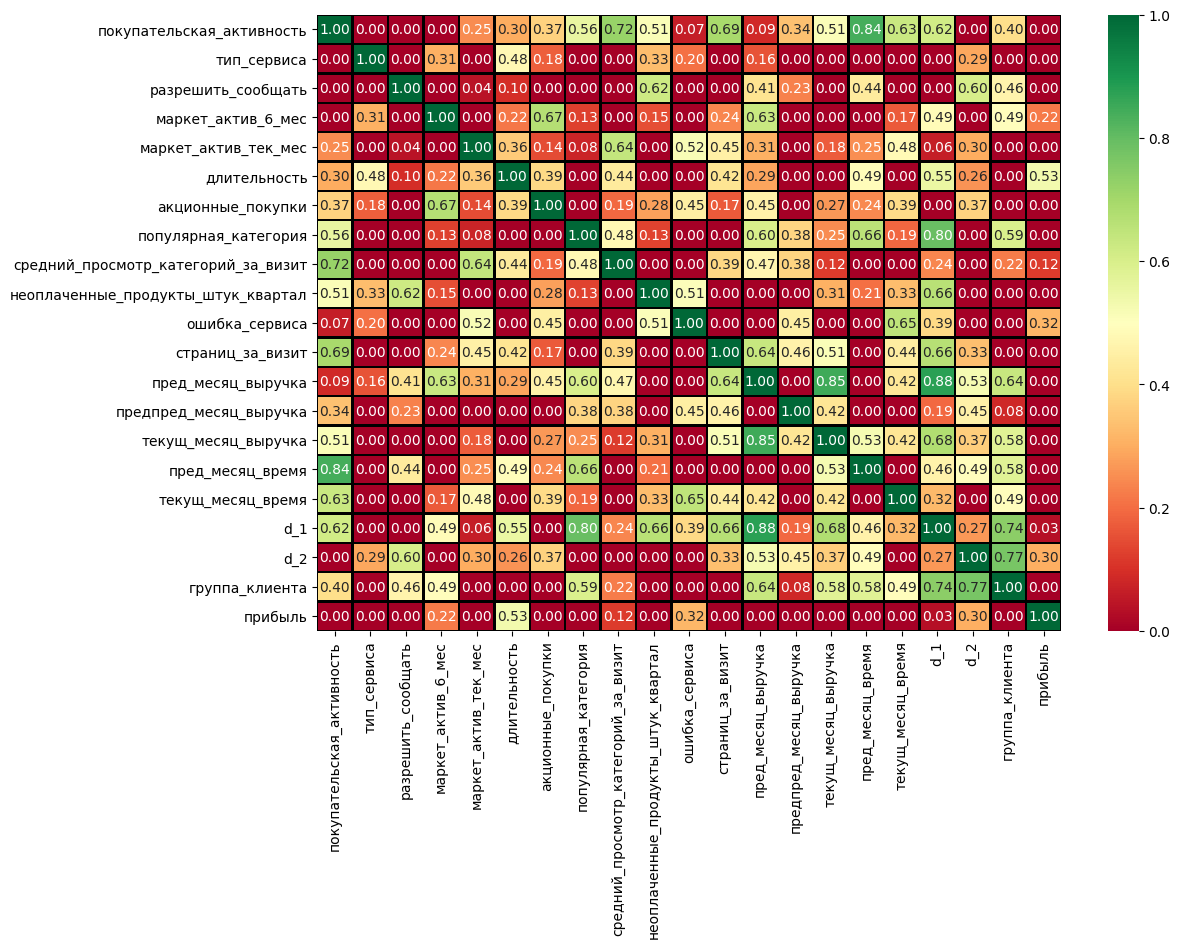

In [98]:
beauty_sale = beauty_sale.drop('id', axis=1)
plt.rcParams['figure.figsize'] = [12, 8]
sns.heatmap(beauty_sale.phik_matrix(interval_cols = int_columns_2), 
            annot = True, fmt=".2f", cmap= 'RdYlGn', linewidths=1, linecolor='black');

В отличие от абстрактного покупателя, на клиента из сегмента "Товары для красоты по акции" наибольшее влияние на параметр "покупательская активность" оказывают следующие факторы:
- "пред месяц время"
- "средний просмотр категорий за визит"
- "страниц за визит"
- "текущ месяц время"
- "d 1" - разница между выручкой за предпредыдущий месяц и предыдущий месяц

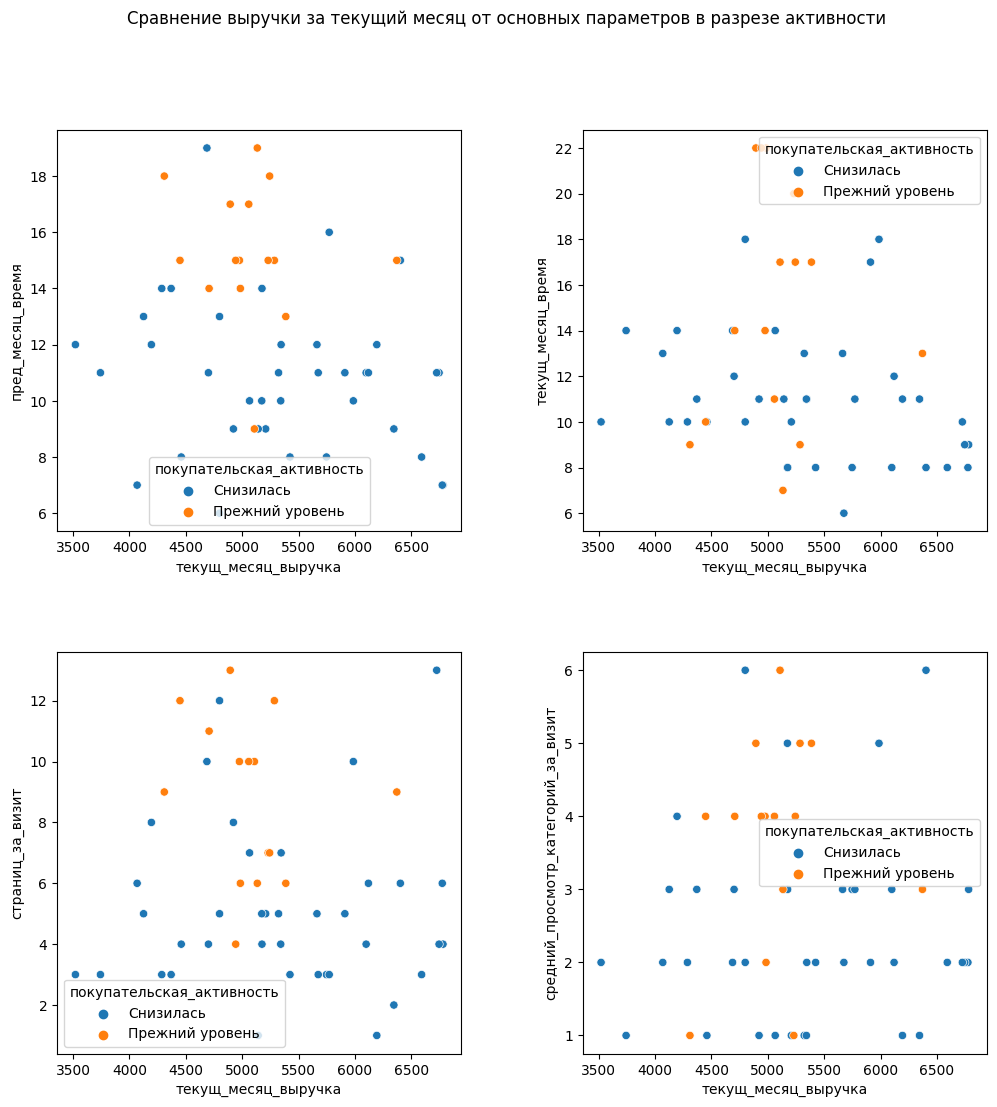

In [99]:
plt.rcdefaults()

fig, axes = plt.subplots(2, 2, figsize=(12,12));
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.suptitle('Сравнение выручки за текущий месяц от основных параметров в разрезе активности')
sns.scatterplot(data=beauty_sale, x='текущ_месяц_выручка', y='пред_месяц_время',
                hue='покупательская_активность', ax=axes[0, 0]);
sns.scatterplot(data=beauty_sale, x='текущ_месяц_выручка', y='текущ_месяц_время',
                hue='покупательская_активность', ax=axes[0, 1]);
sns.scatterplot(data=beauty_sale, x='текущ_месяц_выручка', y='страниц_за_визит', 
                hue='покупательская_активность', ax=axes[1, 0]);
sns.scatterplot(data=beauty_sale, x='текущ_месяц_выручка', y='средний_просмотр_категорий_за_визит',
                hue='покупательская_активность', ax=axes[1, 1]);

Основная доля клиентов в данном сегменте отличается снизившейся покупательской активностью. Такие клиенты провели на сайте не более 14 минут в текущем и прошлом месяце, изучили не более трех категорий товаров, просмотрели не более 6 страниц за визит.   
Полагаю, подобное покупательское поведение будет характерно для всех покупателей товаров преимущественно по акции.   Поэтому и рекомендации можно выдвигать для всего интернет-магазина в целом.

**Предложение по улучшению площадки:**
- **улучшение качества работы сайта** - данные о величине "ошибок сайта", затрагивающих покупателя, носят пугающий характер. Такое большое количество ошибок не может не сказываться на популярности интернет-магазина в целом;
- **улучшение работы с корзиной товаров** - исходя из данных заказчика, у покупателей нет возможности сохранить товар в "Избранном", кроме как оставить его в корзине неоплаченным. Наличие на сайте категории "избранных" товаров существенно повышает лояльность клиентов к сайту;
- **улучшение описания и сравнения товаров** - предположение от отсутствии подробных описаний товаров и опции сравнения товаров между собой базируется на среднем времени, проведенном клиентом на сайте. Все покупки совершаются весьма быстро - клиент словно бы не тратит время на изучение всего ассортимента, с просто покупает то, что первым попалось ему на глаза. Отсутствие полной информации о товаре - это негативный фактор. 
- **изучение характера маркетинговых коммуникаций** - поскольку мы видим из данных, маркетинговые коммуникации работают. Наличие категории "избранных" товаров позволило бы более точно информировать клиента о проходящих акциях на товары. Возможно, сейчас всем клиентам рассылаются одинаковые информационные сообщения;
- **изменение порога минимальной суммы заказа** - это предположение основывается на данных о распределении сумм выручки в разные месяцы. Есть некие пороги сумм, ниже которых не бывает значений выручки от клиентов. Между данными двухмесячной и месячной давности есть снижение этого гипотетического порога с 3800 рублей до 2800 рублей. Возможно, стоило бы убрать этот порог вообще, тогда, гипотетически, это увеличило бы привлекательность покупок для клиентов, предпочитающих товары по акции. Допустим, сейчас они вынуждены (если хотят что-то купить) набирать товар на сумму, превышающую порог, а при его отсутствии могут сразу покупать то, что их интересует. Таким образом, гипотетически, может вырасти общая выручка от такого сегмента покупателей.

**Предложения по дополнению данных:**
- **использование доставки** - нам неизвестно, что входит в "премиум" тип сервиса данной площадки. А также нет информации о возможности доставки заказанных товаров с помощью своей курьерской службы или с помощью других логистических компаний. Использование подобных опций может существенно влиять на лояльность клиентов. Мы видим в перечне товаров отсутствие крупной бытовой техники, которую необходимо доставлять только с помощью транспортного средства, но это не означает, что никому бы из клиентов не понадобилась бы услуга доставки.
- **более полная информация о количестве покупок в месяц** - данные довольно необычно сгруппированы, некоторые параметры зафиксированы для одного визита, некоторые усреднены помесячно за периоды в три или шесть месяцев. Так сложнее отслеживать изменение действий клиентов интернет-магазина. В описании проекта указано, что покупательская активность апеллирует к количеству покупаемых товаров, но в данных нет информации именно о количестве покупаемых товаров.
- **изучение характера маркетинговых коммуникаций** - возможно, если уточнить типы маркетинговых коммуникаций, можно было бы выделить более успешные стратегии влияния на покупательский интерес. Например, видят ли посетители сайта акционные баннеры на сайте? 
- **дополнение информации о пользователях** - скорее всего, посетители региструются на сайте интернет-магазина, используя максимум почтовый адрес или телефон. Можно было бы провести добровольное анкетирование пользователей для сбора информации о возрасте, удовлетворенности сервисом и т.п. 

## Общий вывод

В данном проекте изучалась **задача** о снижении пользовательской активности клиентами интернет-магазина "В один клик". Заказчиком были переданы данные о 1300 клиентах магазина, которые совершали в нем покупки в течение не менее 3 месяцев. Данные описывали взаимодействие покупателей с сайтом (время, потраченное на изучение категорий товаров и страниц с самими товарами, объем ежемесячной выручки от клиентов) и с маркетинговым отделом (данные о типе сервиса клиентов, о количестве маркетинговых коммуникаций с клиентами), а также отдельный файл, в котором в виде некоего числа была зафиксирована среднемесячная прибыль от клиентов.    

Переданные данные были загружены, изучены на соответствие типам данным, избавлены от **неявных дубликатов и выбросов**. Затем данные из первых трех файлов были сгруппированы в общий датафрейм, содержащий данные о 1296 клиентах, которые совершали покупки в интернет-магазине в течение всех трех месяцев, данные о которых были переданы для изучения.   

С помощью графиков были изучены **распределения** параметров в данных. Изучены их особенности и **взаимное влияние** друг на друга с помощью **матрицы корреляции коэффициента Фи**. Тем самым были выявлены наиболее значимые для нашего целевого параметра ("покупательской активности") факторы.   

Для поиска оптимальной модели предсказания целевого параметра был выбран путь перебора и сравнения качества четырех типов моделей и их гиперпараметров с помощью **пайплайна**. В качестве метрики оценки качества предсказания модели была выбрана **метрика ROC_AUC** как наиболее независимая метрика.   

В результате проверки была выявлена наилучшая модель: метод опорных векторов **SVC с ядром rbf** (радиальной базисной функции), а в качестве стандартизации количественных признаков используется **StandardScaler**. Метрика **ROC_AUC данной модели составила 0,913**.

В результате работы модели было выяснено, что наибольшее влияние на определение целевого признака имеют параметры **времени, проведенного на сайте** и **количество просмотренных страниц и категорий товаров**.   
Сами покупатели сильно отличаются своим поведением относительно **доли акционных товаров в покупках**. Меньшая часть клиентов заходит на сайт только для того, чтобы купить **товар по акции**. Именно в ней наблюдается **снижение покупательской активности**. Таких покупателей следует пытаться заинтересовать не только акционными товарами. Возможно, для клиентов было бы интересно получить маркетинговое уведомление не только о тех товарах, на которые в данный момент проходит акция, но и просто письмо с информацией о том, какие новые товары появились в интернет-магазине. Возможно, использовать для этого отзывы довольных клиентов.    

Таже следует уделить внимание **улучшению качества работы сайта** и добавить категорию товаров **избранное**. Анализ этой категории позволил бы маркетологам интернет-магазина осуществлять более клиентоориентированные маркетинговые взаимодействия. 